![image](https://py-rates.fr/assets/welcomePage/logoSmall.png)

# PyratesIA - Model Training

This notebook preprocesses the features vector and train the help policies, defined as multiclass classifiers that predicts from the behavioral features, the help type to provide to the students. 
- Input: The pickles generated by the feature_engineering notebook (pickle/FEATURES, pickle/FEATURES_CONSTANTS, pickle/RECEIVED_HELP_KEYS, pickle/FEATURES_SETS_KEY, pickle/LEVELS_KEYS, pickle/TIME_FEATURES_KEYS_TOTAL) 
- Output: A dictionary with the trained models, their performance, and their predicted values on the test sets

The inputs should be as follows:
- pickle/FEATURES_CONSTANTS: the list of feature names, along with the labels (in our case "help_type") and the student ID 'in our case "student_id")
- pickle/RECEIVED_HELP_KEYS: the different possible value of the labels (in our case the different help types)
- pickle/FEATURES: A nested dictionary with the game levels as the first keys ("Level1", "Level2"...), feature sets as the second keys ("sum_features_nohelp", "meansd_features_nohelp"), the feature names as the third keys ("CO_avg_while_impl", "CO_avg_string_impl"...), and the computed features as the values.
- pickle/LEVELS_KEYS: the list of level keys, i.e., the first keys in pickle/FEATURES 
- pickle/FEATURES_SETS_KEY: the list of feature sets names, i.e., the second key in pickle/FEATURES. This is relevant only if different subsets of features are used for model training. In case only one set of features is needed, then this should just be a list with only one element (the name of the one feature set).
- pickle/TIME_FEATURES_KEYS_TOTAL: the time-based features keys, that we discretize for some classifiers

The output is as follows:

    outputall = {
        "grid_results": levels_results_grid,    
        "grid_trained_classifiers": levels_grid_classifier,
        "grid_predictions": pred_results,
        "grid_true_labels": pred_labels
    }
where:
- grid_results is a dataframe with the performance of the models (by default we compte F1 score, precision, recall)
- grid_trained_classifiers is a nested dictionary with the trained models per game level (1st key), feature sets (2nd key) and model (3rd key). When using k-folds the vlaue is a list of model (one per fold)
- grid_predictions is a similar dictionary where the value are the model's prediction (i.e., the outputs of the models)
- grid_true_labels is the same as grid_predictions but with the true labels (necessary to compute confusing matrices)
    

In [90]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
%matplotlib inline
from dateutil import parser
from locale import normalize
import ipywidgets as widgets
from IPython import display
from statistics import mean
import pickle

from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupShuffleSplit
# from modules.ordinal import OrdinalClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE 
from copy import deepcopy

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning

from sklearn.inspection import permutation_importance


pd.options.display.max_rows = 999 #to be able to print full matrices
# from dill import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

## 1) Load Pickles

In [94]:
with open('pickle/FEATURES_CONSTANTS', 'rb') as f:
    ALL_KEYS = pickle.load(f)

with open('pickle/FEATURES', 'rb') as f:
    levels_processed_dataframes = pickle.load(f)
    
with open('pickle/LABELS_KEY', 'rb') as f:
    LABELS_KEY = pickle.load(f)
    
with open('pickle/FEATURES_SETS_KEY', 'rb') as f:
    FEATURES_SETS = pickle.load(f)
    
with open('pickle/LEVELS_KEYS', 'rb') as f:
    LEVELS_KEYS = pickle.load(f)  
        
with open('pickle/RECEIVED_HELP_KEYS', 'rb') as f:
    RECEIVED_HELP_KEYS = pickle.load(f)
    
with open('pickle/TIME_FEATURES_KEYS_TOTAL', 'rb') as f:
    TIME_FEATURES_KEYS_TOTAL = pickle.load(f)  

## 2) ML Constants

In [122]:
RAND_STATE_SEED = 42 #for reproducibility
EXPORT_SUFFIX = "_run1" #suffix to add to all exported file (for version control)
NBFOLDS = 5 # number of cross validation folds
NBFOLDS_GRID = 10 # number of inner folds for the gris search hyperparameter tuning
LABELS_KEY = "help_type" # the key of the labels in the feature dataframe
STUDENT_ID_KEY = "student_id" # the grouping key used to do cross-validation over users (effectively using the StratifiedGroupKFold function of sklearn)
CORREL_THRESHOLD = 0.8 # thresholds for discarding correlated features (1 means no feature removal) 
SMOTE_MINORITY = True # True/False: to turn on/off Smote over-sampling of the minority classes
MAX_EXECUTION_THRESHOLD = 40 # outlier threshold: students who made too many executions are deemed outliers because this can reveals a gaming-the-system strategy

## 3) Data filtering and outlier removal

Remove game levels where the amount of datapoints (help delivered) is too small, either because the level is too easy, or because not enough students made it to that level

In [96]:
# We opted to remove the game levels where the number of datapoints is substantially lower, 
# effectively less than 50 datapoints (see features_exploration).
del levels_processed_dataframes[LEVELS_KEYS[1]] #level2
del levels_processed_dataframes[LEVELS_KEYS[5]] #level6
del levels_processed_dataframes[LEVELS_KEYS[6]] #level7
del levels_processed_dataframes[LEVELS_KEYS[7]] #level8

Remove outliers, defined as rows with too many executions (indicates a notion avoidance strategy: user playing with random)

In [97]:
NB_USER_STOPPED_EXECUTION_KEY = "EX_tot_user_stopped"
NB_COMPLETED_EXECUTION_KEY = "EX_tot_completed"
REQUESTED_HELP_TOTAL = "FE_tot_requested"

for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    nb_rows_before = level_processed_dataframe.shape[0]
    level_processed_dataframe = level_processed_dataframe.drop(level_processed_dataframe[level_processed_dataframe[NB_USER_STOPPED_EXECUTION_KEY] > MAX_EXECUTION_THRESHOLD].index)
    level_processed_dataframe = level_processed_dataframe.drop(level_processed_dataframe[level_processed_dataframe[NB_COMPLETED_EXECUTION_KEY] > MAX_EXECUTION_THRESHOLD].index)
    nb_rows_after = level_processed_dataframe.shape[0]
    print("Nb deleted rows: ",(nb_rows_before-nb_rows_after))


------------------ Level1 ------------------
Nb deleted rows:  0
------------------ Level3 ------------------
Nb deleted rows:  0
------------------ Level4 ------------------
Nb deleted rows:  3
------------------ Level5 ------------------
Nb deleted rows:  9


## 4) Create the feature sets

Here a feature set is defined as a subset of the features (i.e., a subset of pickle/FEATURES_CONSTANTS). The goal being to train the models on different subsets of features rather than just using all of the available features.

In [98]:
# based on the levels_processed_dataframes dataframe, create one dataframe per feature set defined above in FEATURES_SETS

levels_featuresets_dataframes = {}
print("-------------------------------------(nbdatapoints, nbfeatures)")
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    levels_featuresets_dataframes[level_key] = {}
    for fset_key, fset_columns in FEATURES_SETS.items():
        levels_featuresets_dataframes[level_key][fset_key] = level_processed_dataframe[fset_columns]
        print(level_key, "-", fset_key, ": ", levels_featuresets_dataframes[level_key][fset_key].shape)
    print()

#levels_featuresets_dataframes["Level1"]["sum_features_help_received"]

-------------------------------------(nbdatapoints, nbfeatures)
Level1 - all_features_help_received :  (176, 202)
Level1 - all_features_help_requested :  (176, 200)
Level1 - all_features_nohelp :  (176, 198)
Level1 - sum_features_help_received :  (176, 84)
Level1 - sum_features_help_requested :  (176, 81)
Level1 - sum_features_nohelp :  (176, 80)
Level1 - meansd_features_help_received :  (176, 125)
Level1 - meansd_features_help_requested :  (176, 122)
Level1 - meansd_features_nohelp :  (176, 121)

Level3 - all_features_help_received :  (408, 202)
Level3 - all_features_help_requested :  (408, 200)
Level3 - all_features_nohelp :  (408, 198)
Level3 - sum_features_help_received :  (408, 84)
Level3 - sum_features_help_requested :  (408, 81)
Level3 - sum_features_nohelp :  (408, 80)
Level3 - meansd_features_help_received :  (408, 125)
Level3 - meansd_features_help_requested :  (408, 122)
Level3 - meansd_features_nohelp :  (408, 121)

Level4 - all_features_help_received :  (338, 202)
Level4 -

## 5) ML pipeline steps

### 5.1) Create the k-folds group

By default we used stratified k-folds over students. Stratification means that the label distribution remains balanced across the groups. "Over students" means that all of the datapoints pertaining to a student (eg all of the help they received) are within the same fold, to avoid data contamination.

In [99]:
levels_train_sets = {}
levels_test_sets = {}
level_train_set_index = []
level_test_set_index = []
cv_split_indices = {}
test_set_ratio = 1.0 / NBFOLDS
print("test_set_ratio = ", test_set_ratio)

for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    cv_split_indices[level_key] = []
    # Detour of StratifiedGroupKFold to get stratified AND group aware train-test split
    cv = StratifiedGroupKFold(n_splits=int(1/test_set_ratio),shuffle=True, random_state = RAND_STATE_SEED)
    for level_train_set_index, level_test_set_index in cv.split(level_processed_dataframe,y=level_processed_dataframe[LABELS_KEY], groups=level_processed_dataframe[STUDENT_ID_KEY]):
        cv_split_indices[level_key].append( (level_train_set_index, level_test_set_index) )
       
# print the fold sizes
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    for k in range(NBFOLDS):
        (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
        print(k, ": ", len(level_train_set_index), "/", len(level_test_set_index))
        #print (cv_split_indices[level_key][k][1])

test_set_ratio =  0.2
------------------ Level1 ------------------
0 :  143 / 33
1 :  146 / 30
2 :  141 / 35
3 :  141 / 35
4 :  133 / 43
------------------ Level3 ------------------
0 :  330 / 78
1 :  324 / 84
2 :  330 / 78
3 :  317 / 91
4 :  331 / 77
------------------ Level4 ------------------
0 :  268 / 70
1 :  279 / 59
2 :  268 / 70
3 :  271 / 67
4 :  266 / 72
------------------ Level5 ------------------
0 :  127 / 37
1 :  129 / 35
2 :  128 / 36
3 :  133 / 31
4 :  139 / 25


------------------ Level1 ------------------


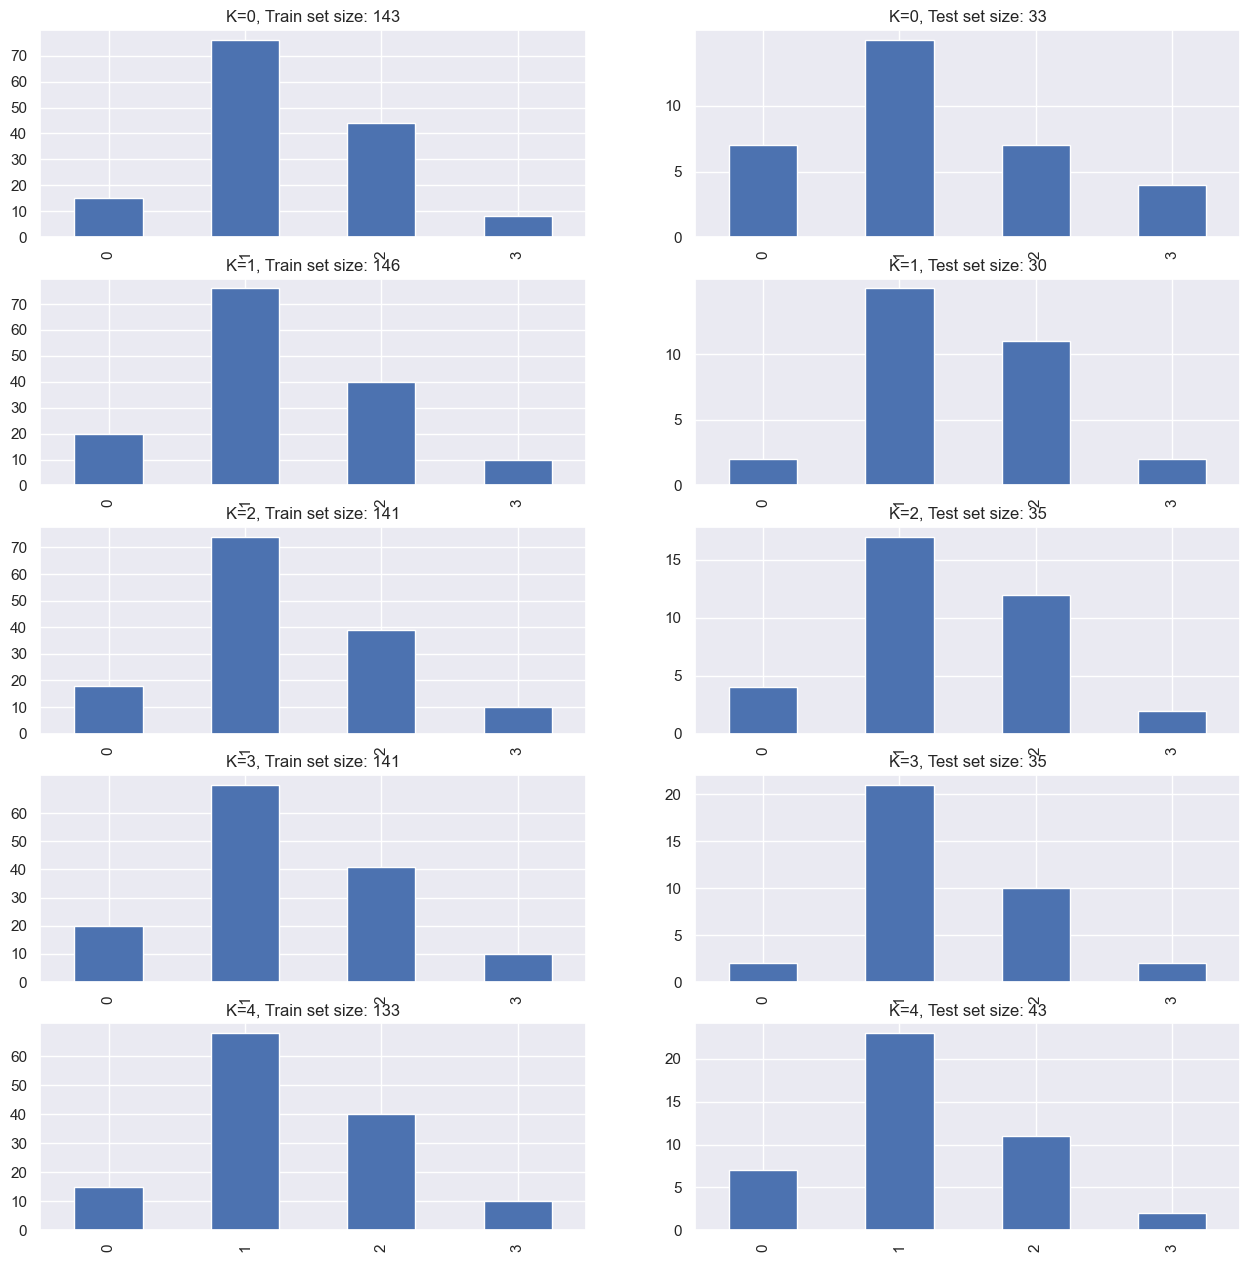

------------------ Level3 ------------------


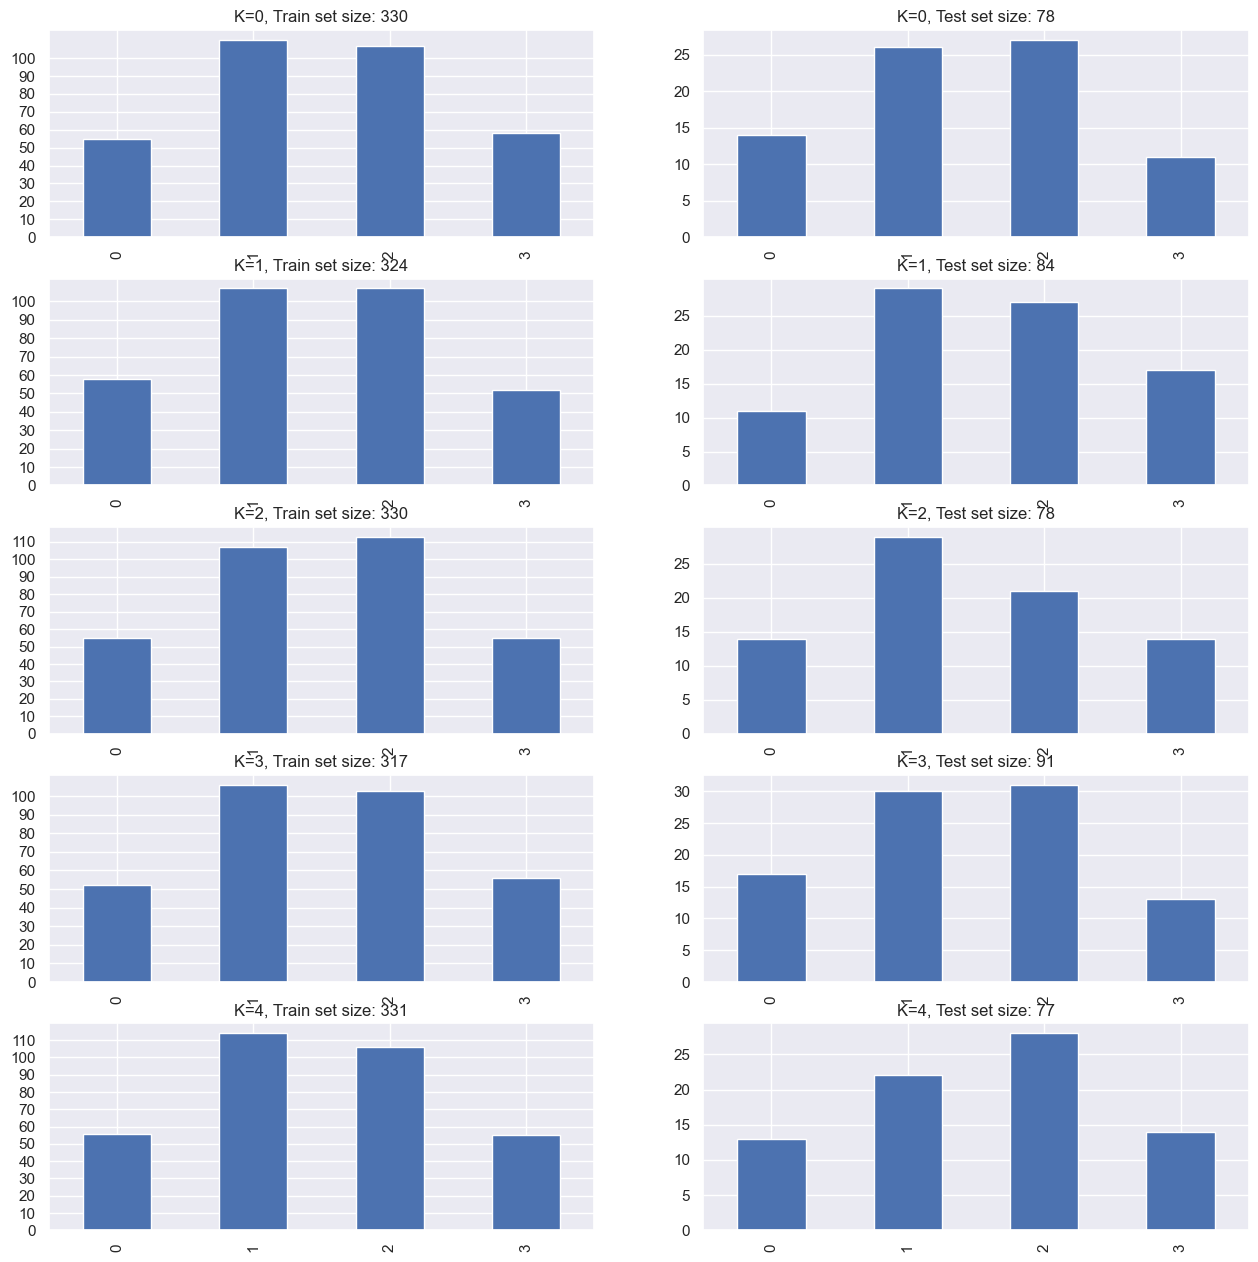

------------------ Level4 ------------------


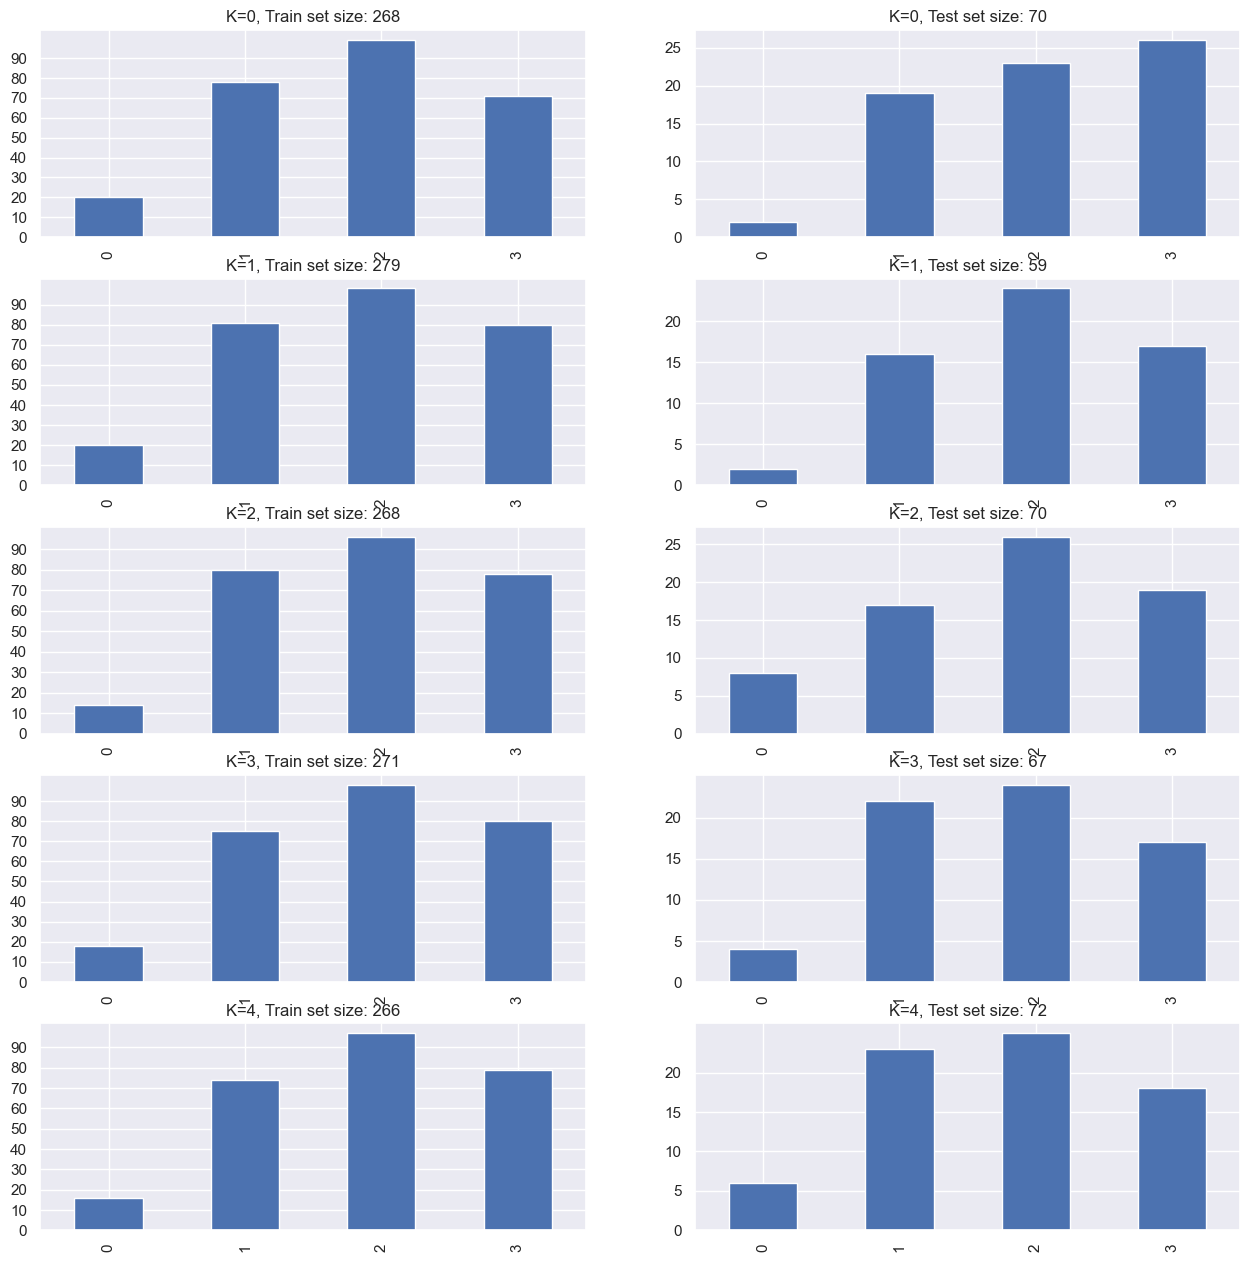

------------------ Level5 ------------------


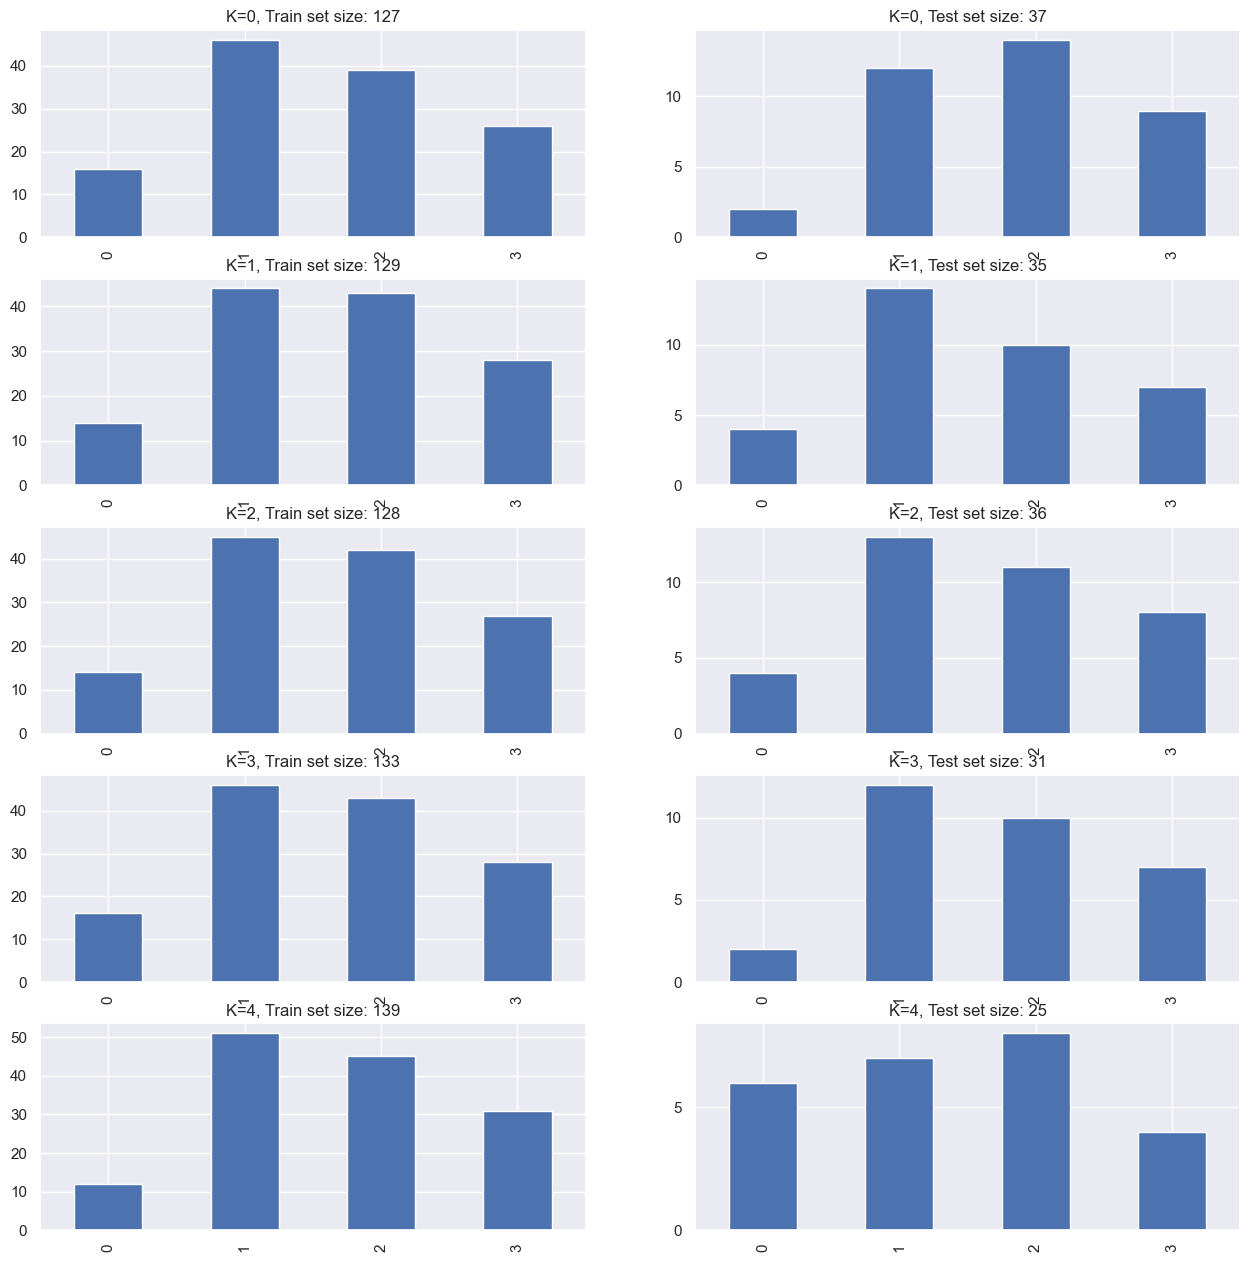

In [100]:
#show the label distribution per folds
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    fig = plt.figure()
    for k in range(NBFOLDS):
        (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
    
        level_train_set = level_processed_dataframe.iloc[level_train_set_index]
        level_test_set = level_processed_dataframe.iloc[level_test_set_index]

        #  Display class distribution
        train_counts = level_train_set[LABELS_KEY].value_counts(normalize=False).sort_index()
        ax = plt.subplot(NBFOLDS, 2, k*2+1)
        ax.title.set_text("K={}, Train set size: {}".format(k, len(level_train_set)))
        train_counts.plot(kind='bar')
        plt.yticks(np.arange(0, max(train_counts), 10))
        #plt.show()
        
        test_counts = level_test_set[LABELS_KEY].value_counts(normalize=False).sort_index()
        ax = plt.subplot(NBFOLDS, 2, k*2+2)
        ax.title.set_text("K={}, Test set size: {}".format(k, len(level_test_set)))
        test_counts.plot(kind='bar')
        plt.yticks(np.arange(0, max(test_counts), 5))
        
        """levels_train_sets[level_key]= level_train_set
        levels_test_sets[level_key]= level_test_set"""
    plt.subplots_adjust(bottom=1.5, right=2,top=4)
    plt.show()

### 5.2) Function to split the features and labels

In [101]:
def feature_label_group_split(dataset):
    dataset_features = dataset.drop(columns=[LABELS_KEY,STUDENT_ID_KEY]) #remove the labels and student_id from the predictors
    dataset_labels = dataset[LABELS_KEY].copy()
    dataset_groups = dataset[STUDENT_ID_KEY].copy()
    return (dataset_features, dataset_labels,dataset_groups)

def feature_label_split(dataset):
    dataset_features = dataset.drop(columns=[LABELS_KEY,STUDENT_ID_KEY])
    dataset_labels = dataset[LABELS_KEY].copy()
    return (dataset_features, dataset_labels)

### 5.3) Functions for feature selections

In [102]:
# Create a custom transformer to delete irrelevant features (all values are the same)
class DeleteIrrelevantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or ** kargs
        pass
    def fit(self, X, y = None):
        self.unused_features = []
        for key in X.columns:
        # E_CONTAMINATION
            nb_values = X[key].value_counts()
            if len(nb_values) == 1: # If all the values are the same
                # print("Deleted feature :",key)
                self.unused_features.append(key)
        # print("Remain features: ",len(X.columns)-len(self.unused_features))
        return self
    def transform(self, X, y = None):
        # print("Number of deleted features",len(self.unused_features))
        modified_X = X.drop(columns=self.unused_features)    
        return modified_X

In [103]:
# Create a custom transformer to delete highly correlated features
class DeleteCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = 0.9): # no *args or ** kargs
        self.threshold = threshold
        self.to_drop = []
        
    def fit(self, X, y = None):
        if isinstance(X, pd.DataFrame):
            corr_matrix = X.corr().abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            self.to_drop = [column for column in upper.columns if any(upper[column] >= self.threshold)]
        else:
            corr_matrix = np.absolute(np.corrcoef(X, rowvar=False))
            upper = corr_matrix*np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
            self.to_drop = [column for column in range(upper.shape[1]) if any(upper[:,column] >= self.threshold)]
        return self
    
    def transform(self, X, y = None):
        if isinstance(X, pd.DataFrame):
            X_reduced = X.drop(columns = self.to_drop)
        else:
            X_reduced = np.delete(X, self.to_drop, axis=1)
        return X_reduced

In [104]:
# Create a custom transformer to discretize time features (used only for the Naive Bayes Classifier as it does not handles continuous data)
class TimeSpendDiscretizer(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or ** kargs
        pass
    def fit(self, X, y = None):
        self.discretizer = {}
        for time_feature in TIME_FEATURES_KEYS_TOTAL:
            if time_feature in X.columns:
                self.discretizer[time_feature] = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
                self.discretizer[time_feature].fit(X[[time_feature]])
        return self
    def transform(self, X, y = None):
        modified_X = X.copy()
        for time_feature in TIME_FEATURES_KEYS_TOTAL:
            if time_feature in modified_X.columns:
                modified_X[time_feature] = self.discretizer[time_feature].transform(modified_X[[time_feature]])
        return modified_X


In [105]:
# transformer to normalize the features
data_scaler = MinMaxScaler()

### 5.4) Model evaluation function

evaluate_model(): train and test the models in k-folds cross validation over students, and compute the F1, Precision and Recall.
This is the "simple approach" that trains the models without hyperparameter tuning.

In [106]:
def evaluate_model(pipeline,features,labels, train_groups, scores = ["precision_weighted", "recall_weighted", "f1_weighted"]):
    stratified_group_cross_val = StratifiedGroupKFold(n_splits=NBFOLDS,shuffle = True, random_state = RAND_STATE_SEED)
    results = cross_validate(pipeline,features,labels,cv=stratified_group_cross_val, scoring = scores, groups=train_groups)
    return results


### 5.5) Pipeline definition for each classifier we consider (based on sklearn)

We define one pipeline per classifier, and simply save the different pipelines in a list. This means more pipeline can be added (or deleted) as needed.

In [107]:
#Dummy baseline from sklearn
dummy_random_clf_pipe = Pipeline([
    ("dummy_random_clf", DummyClassifier(strategy="uniform"))
])

In [108]:
# Ordered baseline
# This custom baseline is based on the simple approach of delivering the help type in an odered manner, granted that there is some notions of ordering.
# In our case the help types of ordered based on how much they reveal about the final solutions, from simply reminded the goal of the game level to derectly providing the correct solution.

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class OrderedBaseline(BaseEstimator):
    def __init__(self, random_state=None):
        self.random_state = random_state

    # fit model (Nothing to do for the baseline)
    def fit(self, X=None, y=None):
        pass

    #predict (Escalate help level)
    def predict(self, X):
        res = []
        
        #Check if help received available
        if all(value in X.columns for value in RECEIVED_HELP_KEYS):
            for ind,row in X.iterrows():
                help_l = [row[RECEIVED_HELP_KEYS[0]], row[RECEIVED_HELP_KEYS[1]], \
                           row[RECEIVED_HELP_KEYS[2]], row[RECEIVED_HELP_KEYS[3]] ]
                help_given_index = [i for i, x in enumerate(help_l) if x > 0]
                if len(help_given_index) == 0: #no help ever given = predict first help
                    res.append(0)
                else: #predict the next help level
                    max_help = max(help_given_index)
                    res.append(min(max_help+1, 3))
        
        #check if help count available
        elif REQUESTED_HELP_TOTAL in X.columns:
            for ind,row in X.iterrows():
                if row[REQUESTED_HELP_TOTAL] == 0: #no help ever given = predict first help
                    res.append(0)
                else: #predict the next help level
                    res.append(int(min(row[REQUESTED_HELP_TOTAL]+1, 3)))
                
        #otherwise cannot do the prediction
        else:
            res = [-1]*len(X.index)
        return res

#TEST
"""for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        print(f"    --------------- {fset_key} ---------------")    
        fset_dataframe = level_processed_dataframe[fset_columns]
        level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe)
        clf = OrderedBaseline()
        clf.fit(level_features, level_labels)
        print(clf.predict(level_features))
    break"""
    

#Important to not remove any features as part of the pipeline as we need to keep the features on previous help received
ordered_clf_pipe = Pipeline([
    ("dummy_random_clf", OrderedBaseline())
])



In [109]:
#Multinomial Naive Bayes classifier
time_spend_discretizer = TimeSpendDiscretizer()
features_deleter = DeleteIrrelevantFeatures()
data_scaler = MinMaxScaler()

naive_bayes_clf_pipe = Pipeline([
    ("time_spend_discretizer",time_spend_discretizer),
    ("feature_deleter",VarianceThreshold()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    #('feature_selection', SelectPercentile(chi2, percentile=90)),
    ("data_scaler", data_scaler),
    ("naive_bayes_clf", MultinomialNB())
])

In [110]:
#Logistic regression
features_deleter = DeleteIrrelevantFeatures()
data_scaler = MinMaxScaler()

logistic_regression_clf_pipe = Pipeline([
    ("feature_deleter",VarianceThreshold()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    #('feature_selection', SelectPercentile(chi2, percentile=90)),
    ("data_scaler", data_scaler),
    ("logistic_regression_clf", LogisticRegression(random_state=RAND_STATE_SEED))
])

In [111]:
#SVM
features_deleter = DeleteIrrelevantFeatures()
data_scaler = MinMaxScaler()

svm_clf_pipe = Pipeline([
    ("feature_deleter",VarianceThreshold()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    #('feature_selection', SelectPercentile(chi2, percentile=90)),
    ("data_scaler", data_scaler),
    ("svm_gaussian_clf", SVC(kernel="rbf"))
])

In [112]:
#Decision tree
features_deleter = DeleteIrrelevantFeatures()
features_correlated = DeleteCorrelatedFeatures(0.8)
data_scaler = MinMaxScaler()

decision_tree_clf_pipe = Pipeline([
    ("feature_deleter",features_deleter),
    ("data_scaler", data_scaler),
    ("decision_tree_clf", DecisionTreeClassifier(random_state = RAND_STATE_SEED))
])

In [113]:
#Random Forests
features_deleter = DeleteIrrelevantFeatures()
features_correlated = DeleteCorrelatedFeatures(0.8)
data_scaler = MinMaxScaler()

random_forest_clf_pipe = Pipeline([
    ("feature_deleter",VarianceThreshold()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    #('feature_selection', SelectPercentile(chi2, percentile=90)),
    ("data_scaler", data_scaler),
    ("random_forest_clf", RandomForestClassifier(random_state = RAND_STATE_SEED))
])

In [114]:
#Crate the final list of all classifiers
classifiers = {
    "Dummy random": dummy_random_clf_pipe,
    "Ordered baseline": ordered_clf_pipe,
    "Naive Bayes": naive_bayes_clf_pipe,
    "Logistic regression":logistic_regression_clf_pipe,
    "SVM": svm_clf_pipe,
    "Decision Tree":decision_tree_clf_pipe,
    "Random Forest": random_forest_clf_pipe
}

## 6) Model training and evaluation (no hyper-parameter tuning)

Here we first train and evaluate the models using the default values in sklearn for the hyperparameters of the models.
We compte the F1 score, precision and recall using the evaluate_model() function in stratified k-folds cross validation over sturents (k=NBFOLDS).

In [115]:
metrics = ["Precision_m",
            "Precision_std",
            "Recall_m",
            "Recall_std",
            "F1_score_m",
            "F1_score_std"]

fold_results = []

#iterate over the game level, feature sets and fold to train the models
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")         
    
    for fset_key, fset_columns in FEATURES_SETS.items():
        print(f"    --------------- {fset_key} ---------------")    
        fset_dataframe = level_processed_dataframe[fset_columns]
        level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe)

        for classifier_name, classifier in classifiers.items():
            cv_results = evaluate_model(classifier, level_features, level_labels, level_groups)
            for k in range(NBFOLDS):
                fold_results.append({
                    "level_key": level_key,
                    "features_set": fset_key,
                    "K": k,
                    "classifier": classifier_name,
                    "Precision":cv_results["test_precision_weighted"][k],
                    "Recall":cv_results["test_recall_weighted"][k],
                    "F1_score":cv_results["test_f1_weighted"][k]
                })

levels_results = pd.DataFrame.from_records(fold_results) 
print("Done")

------------------ Level1 ------------------
    --------------- all_features_help_received ---------------
    --------------- all_features_help_requested ---------------
    --------------- all_features_nohelp ---------------
    --------------- sum_features_help_received ---------------
    --------------- sum_features_help_requested ---------------
    --------------- sum_features_nohelp ---------------
    --------------- meansd_features_help_received ---------------
    --------------- meansd_features_help_requested ---------------
    --------------- meansd_features_nohelp ---------------
------------------ Level3 ------------------
    --------------- all_features_help_received ---------------
    --------------- all_features_help_requested ---------------
    --------------- all_features_nohelp ---------------
    --------------- sum_features_help_received ---------------
    --------------- sum_features_help_requested ---------------
    --------------- sum_features_nohelp --

In [120]:
#print results
pd.pivot_table(levels_results.drop("K", axis=1), index=['level_key','features_set','classifier'], aggfunc='mean')

F1_score  \
level_key features_set                   classifier                      
Level1    all_features_help_received     Decision Tree        0.638581   
                                         Dummy random         0.314171   
                                         Logistic regression  0.684590   
                                         Naive Bayes          0.684446   
                                         Ordered baseline     0.422137   
                                         Random Forest        0.725653   
                                         SVM                  0.682086   
          all_features_help_requested    Decision Tree        0.594912   
                                         Dummy random         0.251123   
                                         Logistic regression  0.655824   
                                         Naive Bayes          0.607746   
                                         Ordered baseline     0.093807   
                                         Random Forest        0.722456   
                                         SVM                  0.625304   
          all_features_nohelp            Decision Tree        0.633742   
                                         Dummy random         0.284781   
                                         Logistic regression  0.659659   
                                         Naive Bayes          0.597550   
                                         Ordered baseline     0.000000   
                                         Random Forest        0.713263   
                                         SVM                  0.619329   
          meansd_features_help_received  Decision Tree        0.634400   
                                         Dummy random         0.273892   
                                         Logistic regression  0.697107   
                                         Naive Bayes          0.664184   
                                         Ordered baseline     0.422137   
                                         Random Forest        0.732345   
                                         SVM                  0.701829   
          meansd_features_help_requested Decision Tree        0.660477   
                                         Dummy random         0.363286   
                                         Logistic regression  0.654995   
                                         Naive Bayes          0.568572   
                                         Ordered baseline     0.000000   
                                         Random Forest        0.743422   
                                         SVM                  0.626211   
          meansd_features_nohelp         Decision Tree        0.645044   
                                         Dummy random         0.252553   
                                         Logistic regression  0.642699   
                                         Naive Bayes          0.568572   
                                         Ordered baseline     0.000000   
                                         Random Forest        0.756211   
                                         SVM                  0.620914   
          sum_features_help_received     Decision Tree        0.648569   
                                         Dummy random         0.261455   
                                         Logistic regression  0.647823   
                                         Naive Bayes          0.666411   
                                         Ordered baseline     0.422137   
                                         Random Forest        0.697274   
                                         SVM                  0.616062   
          sum_features_help_requested    Decision Tree        0.623804   
                                         Dummy random         0.301362   
                                         Logistic regression  0.605510   
                                         Naive Bayes          0.54

## 7) Model training and evaluation with hyper-parameter tuning

We repeat the process of 6) but this time with hyper-parameter tuning, using the GridSearch mechanism from sklearn. This means we use stratified nested cross-validation over students, with the grid search applied at the inner loop of the nested cross validation.

Notice that we have defined a small and a large grid for each hyperparameter (cf. code below), but we typically use the small one.

In [123]:
levels_results_grid = {}

#this is for the inner level of the nested cross-validation
stratified_group_cross_val = StratifiedGroupKFold(n_splits=NBFOLDS_GRID, shuffle = True, random_state = RAND_STATE_SEED)

#define the grid for each model
param_grid_nb = [{
    # Default value in sklearn: 1.0
    #'naive_bayes_clf__alpha': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001] #large grid
    'naive_bayes_clf__alpha': [1.0, 0.1, 0.01] #small grid
}]

param_grid_lr = [{
    # Default value in sklearn: 1.0
    #'logistic_regression_clf__C': [100.0, 50.0, 25.0, 10.0, 5.0, 1.0, 0.5, 0.1], #large grid
    'logistic_regression_clf__C': [100.0, 10.0, 1.0], #small grid
    #defrault: 100
    'logistic_regression_clf__max_iter': [200]
}]

param_grid_svm = [{
    # Default value in sklearn: 1.0
    #'svm_gaussian_clf__C': [100.0, 50.0, 25.0, 10.0, 5.0, 1.0, 0.5, 0.1], #large grid
    'svm_gaussian_clf__C': [100.0, 10.0, 1.0], #small grid
    # Default value in sklearn: 1.0
    #'svm_gaussian_clf__gamma': [10, 1.0, 0.5, 0.1, 0.01, 0.001, 0.0001], #large grid
    'svm_gaussian_clf__gamma': [1.0, 0.1, 0.01], #small grid
    # Default value in sklearn: rbf
    'svm_gaussian_clf__kernel': ['rbf', 'poly', 'sigmoid']
}]

        
param_grid_rf = [{
    # Default value in sklearn: 100
    #"random_forest_clf__n_estimators": [20, 50, 100, 200, 500], #large grid
    "random_forest_clf__n_estimators": [50, 100, 200], #small grid
    # Default value in sklearn: None
    #"random_forest_clf__max_depth" : [4,6,8,10,12,14,16,18,None],    #large grid
    "random_forest_clf__max_depth" : [6,12,None],    #small grid
}]


#add all of the grids in a dict
grids = {
    "Dummy random": dummy_random_clf_pipe,
    "Ordered baseline": ordered_clf_pipe,
    "Naive Bayes": GridSearchCV( 
                                estimator = naive_bayes_clf_pipe,
                                param_grid = param_grid_nb,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1),
    "Logistic regression": GridSearchCV( 
                                estimator = logistic_regression_clf_pipe,
                                param_grid = param_grid_lr,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1),
    "SVM": GridSearchCV( 
                                estimator = svm_clf_pipe,
                                param_grid = param_grid_svm,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1),
    "Random Forest": GridSearchCV( 
                                estimator = random_forest_clf_pipe,
                                param_grid = param_grid_rf,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1)
}


if SMOTE_MINORITY: #oversample minority classes with SMOTE
    smoter = SMOTE(random_state=RAND_STATE_SEED)
        
fold_results = []
pred_results = {}
pred_labels = {}
levels_grid_classifier = {}

#iterate over the game level, feature sets and fold to train the models
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    pred_results[level_key] = {}
    pred_labels[level_key] = {}
    levels_grid_classifier[level_key] = {}
       
    for fset_key, fset_columns in FEATURES_SETS.items():
        print(f"    --------------- {fset_key} ---------------")
        pred_results[level_key][fset_key] = {}
        pred_labels[level_key][fset_key] = {}
        levels_grid_classifier[level_key][fset_key] = {}
        
        #keep only features relevant to the current features sets
        fset_dataframe = level_processed_dataframe[fset_columns]
    
        for k in range(NBFOLDS):
            print(f"------------------ {k} ------------------")      
            (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
            level_train_set = fset_dataframe.iloc[level_train_set_index]
            level_test_set = fset_dataframe.iloc[level_test_set_index]

            #level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe) #for the baselines
            level_train_set_features, level_train_set_labels, level_train_set_groups  = feature_label_group_split(level_train_set)
            level_test_set_features, level_test_set_labels  = feature_label_split(level_test_set)
            
            if SMOTE_MINORITY: #oversample minority classes, in the train sets ONLY
                (level_train_set_features, level_train_set_labels) = smoter.fit_resample(level_train_set_features, level_train_set_labels)
                level_train_set_groups = range(0, len(level_train_set_labels)) #within-train-set groups make no sense anymore with SMOTE
                
            for classifier_name, grid_pipeline in grids.items():
                if classifier_name not in pred_results[level_key][fset_key]: pred_results[level_key][fset_key][classifier_name] = [] 
                if classifier_name not in pred_labels[level_key][fset_key]: pred_labels[level_key][fset_key][classifier_name] = []
                if classifier_name not in levels_grid_classifier[level_key][fset_key]: levels_grid_classifier[level_key][fset_key][classifier_name] = []

                if classifier_name == "Dummy random" or classifier_name == "Ordered baseline": #no grid search for the baselines
                    grid_pipeline.fit(level_train_set_features,level_train_set_labels)
                    grid_predictions = grid_pipeline.predict(level_test_set_features)
                    fold_results.append({
                        "level_key": level_key,
                        "features_set": fset_key,
                        "K": k,
                        "classifier": classifier_name,
                        "grid_F1": "",
                        "grid_params": "",
                        "precision": precision_score(level_test_set_labels, grid_predictions, average='weighted'),
                        "recall": recall_score(level_test_set_labels, grid_predictions, average='weighted'),
                        "f1_score":f1_score(level_test_set_labels, grid_predictions, average='weighted')
                    })
                    pred_results[level_key][fset_key][classifier_name] += list(grid_predictions)
                    pred_labels[level_key][fset_key][classifier_name] += list(level_test_set_labels)  
                else:
                    grid_pipeline.fit(level_train_set_features,y=level_train_set_labels, groups=level_train_set_groups)
                    grid_predictions = grid_pipeline.predict(level_test_set_features)
                    print(classifier_name)
                    print(f"--Best score: {f1_score(level_test_set_labels, grid_predictions, average='weighted')}")
                    print("--Best params: ",grid_pipeline.best_params_)

                    fold_results.append({
                        "level_key": level_key,
                        "features_set": fset_key,
                        "K": k,
                        "classifier": classifier_name,
                        "grid_F1": grid_pipeline.best_score_,
                        "grid_params" : str(grid_pipeline.best_params_),
                        "precision": precision_score(level_test_set_labels, grid_predictions, average='weighted'),
                        "recall": recall_score(level_test_set_labels, grid_predictions, average='weighted'),
                        "f1_score":f1_score(level_test_set_labels, grid_predictions, average='weighted')
                    })

                    levels_grid_classifier[level_key][fset_key][classifier_name].append(deepcopy(grid_pipeline.best_estimator_))
                    pred_results[level_key][fset_key][classifier_name] += list(grid_predictions)
                    pred_labels[level_key][fset_key][classifier_name] += list(level_test_set_labels)

levels_results_grid = pd.DataFrame.from_records(fold_results) 
print("Done")

------------------ Level1 ------------------
    --------------- all_features_help_received ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6569592024137477
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5072734751879137
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5493857493857494
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.49790108881017975
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 1 ------------------
Fitting 10 folds for each of 3 ca

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6342058562555457
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6317314022383147
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7975753278979085
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.7698587127158556
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.7385661957090529
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 ca

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5373881416662165
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5915650006559098
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.566221657130748
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 50}
------------------ 1 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6896296296296296
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5041269841269842
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5202402402402402
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.8388888888888888
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 2 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6151111111111112
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6544099378881988
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.612763580505516
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7990754151122814
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6484563055991628
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.7583060214639162
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.7661911276138362
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.8175510204081634
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6418946648426812
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.6592878166065581
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 c

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.7224046140195208
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6964749536178108
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7712554112554113
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 100}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6759183673469388
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.7127917833800187
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6867956989247311
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.7118367346938774
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.774132104454685
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 100}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6332506203473947
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.6621658393086964
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6593671274961597
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6061183261183262
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7823979591836734
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 50}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6150881405193657
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.670972270972271
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 c

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6268878648233486
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.7513112491373362
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'poly'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7129345531315976
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.7199427139276763
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.7260651629072681
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6548106548106548
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'poly'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7847746456442107
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.576538451522175
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5876614987080103
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 c

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.684292297564187
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6595918367346939
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.677105324888576
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6385231371110703
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.7260651629072681
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 can

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6487367479700842
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6264181221077773
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7683077108835927
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 200}
    --------------- all_features_help_requested ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.4881034846014684
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.542914979757085
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6378669407515561
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6830733369194909
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6570045793450049
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5018041381369055
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5307762666806846
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5485695364629989
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6097412593380336
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5803672400374049
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5059984341899236
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 ca

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5709397833207357
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.597133031929865
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7007395286705631
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5690691741241848
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6053113553113553
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6466459542146276
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6557759108214005
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.4511576840489307
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5072728767310049
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 ca

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.48131541451680004
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.45927623574682397
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6255048343826438
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
    --------------- sum_features_help_received ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.677017781877117
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.7439847733965381
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_re

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6260413607352383
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.677485493230174
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7092026253316577
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
    --------------- sum_features_help_requested ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.4397176897176897
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5214727660391929
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_re

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6134953595536491
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6417683358628593
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6955562428575921
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.4798923655651832
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.6033681231049653
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 c

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.4995638719776651
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6457957218932828
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6634241575418046
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 200}
    --------------- sum_features_nohelp ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.40002072002072003
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5071733821733821
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regre

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6525079858413191
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6459634244994047
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.703082566087715
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6973015873015873
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.7084316861665301
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 ca

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6794792918443633
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.7108048414170864
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7420503554957336
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
    --------------- meansd_features_help_requested ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.41814251639833033
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.44414117873870196
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.44916072553579967
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'sigmoid'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.5462342427025302
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 50}
------------------ 1 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5638127978464114
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.6313517831374975
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5116833780180126
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5061507479968131
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6325404854816619
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
    --------------- meansd_features_nohelp ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.4284188034188035
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.45587916721692817
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.4711738932688196
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'sigmoid'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.5043746281543395
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 1 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5638127978464114
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.6313517831374975
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5251606538239251
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.492826672064412
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.5360576923076923
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 200}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.46219362614856985
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5001967729240456
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.47194901064870104
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'sigmoid'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6585683175544926
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ Level4 ------------------
    --------------- all_features_help_received ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6880490291354637
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.6379599567099566
--Best params: 

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6143523616871166
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6505061732939386
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7326411421155095
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 50}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6244739057239057
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6176749767175299
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5589810887189919
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6444255039493135
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 100}
    --------------- all_features_help_requested ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5902210884353741
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.6192553908355795
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6509312145923245
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6554276341482465
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7796610169491526
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 200}
------------------ 2 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5026471590425079
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5843633283429203
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 2

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.590134791343195
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6598048717451702
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6966097157994813
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.46822439561410145
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.6453598484848485
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 c

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5121815308044122
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5977481766725953
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6475036075036076
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5651219100174559
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5976181304571134
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6412887200467563
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7645634916018685
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5305775619729108
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5652721088435375
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6549294344603513
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6335520201191843
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7474779445061631
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6649095117845119
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.7458036490297449
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6167909633333838
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5978173141032389
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6615305598356446
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 2 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5129204129204129
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5464004732327714
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 ca

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5968533184418047
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5778651635950507
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6525207296849088
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5419931209404893
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.660680620781363
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6386574074074074
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.626418439716312
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 50}
    --------------- sum_features_nohelp ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5921056409576817
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5364790764790764
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6110686415034241
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5973376623376623
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6324475726497971
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 50}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6938271724804178
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6852887180596461
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6425373134328359
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7502125099759049
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 100}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.625290245047084
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.6654776936026936
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6490955304680797
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6503981585168596
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
    --------------- meansd_features_help_requested ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5517881072949085
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5526884437985721
--Best params:  {'logistic_regression_clf__C': 10.0, 'logi

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.559563387077988
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6175246217890141
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7311174122547317
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 50}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5328912933737181
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5331048581048581
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5478066619370967
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.5984093259329397
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
    --------------- meansd_features_nohelp ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5584952225734524
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5757871396895788
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.637835075493612
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6612451041022469
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 50}
------------------ 1 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.4620213433772755
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5313357546408394
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5621667023240704
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7232457217718823
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.541026771642492
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5353211517165005
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6202752728998576
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6395010748933292
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 50}
------------------ 3 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.557000710732054
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5742292135270037
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.6316417910447761
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.7506451585609368
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 200}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5152226631393299
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.5220971767024398
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5327071767059253
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.5758592113081277
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ Level5 ------------------
    --------------- all_features_help_received ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5758558558558559
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.6293309119396076
--Best params:  {'log

Naive Bayes
--Best score: 0.2782745098039216
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.3449187675070028
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.26755555555555555
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'sigmoid'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.3573856209150327
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 200}
    --------------- all_features_nohelp ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5443243243243243
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each 

Naive Bayes
--Best score: 0.36099999999999993
--Best params:  {'naive_bayes_clf__alpha': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.31388235294117645
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.3316078431372549
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.45623529411764707
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 100}
    --------------- sum_features_help_requested ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5134304796950254
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for e

Naive Bayes
--Best score: 0.34387301587301594
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.2603438914027149
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.27936507936507937
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.4038095238095238
--Best params:  {'random_forest_clf__max_depth': 12, 'random_forest_clf__n_estimators': 50}
    --------------- meansd_features_help_received ---------------
------------------ 0 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.5197246936377371
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.529192546583851
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.49492063492063504
--Best params:  {'svm_gaussian_clf__C': 10.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'poly'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6077810388369395
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 200}
------------------ 2 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6079207191276157
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5800552104899931
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.529192546583851
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.5692776788428963
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6462111801242236
--Best params:  {'random_forest_clf__max_depth': 6, 'random_forest_clf__n_estimators': 200}
------------------ 2 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.6079207191276157
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.5800552104899931
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 c

C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression
--Best score: 0.4431643625192012
--Best params:  {'logistic_regression_clf__C': 100.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 27 candidates, totalling 270 fits
SVM
--Best score: 0.48271889400921664
--Best params:  {'svm_gaussian_clf__C': 100.0, 'svm_gaussian_clf__gamma': 0.1, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Random Forest
--Best score: 0.6454224892255452
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 50}
------------------ 4 ------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Naive Bayes
--Best score: 0.3467012987012987
--Best params:  {'naive_bayes_clf__alpha': 0.01}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Logistic regression
--Best score: 0.34952380952380957
--Best params:  {'logistic_regression_clf__C': 10.0, 'logistic_regression_clf__max_iter': 200}
Fitting 10 folds for each of 

In [124]:
#display results
pd.pivot_table(levels_results_grid.drop("K", axis=1), index=['level_key','features_set','classifier'], aggfunc='mean')

f1_score  \
level_key features_set                   classifier                      
Level1    all_features_help_received     Dummy random         0.306415   
                                         Logistic regression  0.673710   
                                         Naive Bayes          0.668313   
                                         Ordered baseline     0.422137   
                                         Random Forest        0.724724   
                                         SVM                  0.642874   
          all_features_help_requested    Dummy random         0.293100   
                                         Logistic regression  0.598654   
                                         Naive Bayes          0.660755   
                                         Ordered baseline     0.093807   
                                         Random Forest        0.738936   
                                         SVM                  0.624727   
          all_features_nohelp            Dummy random         0.276532   
                                         Logistic regression  0.622704   
                                         Naive Bayes          0.639609   
                                         Ordered baseline     0.000000   
                                         Random Forest        0.750605   
                                         SVM                  0.636957   
          meansd_features_help_received  Dummy random         0.303485   
                                         Logistic regression  0.670666   
                                         Naive Bayes          0.680303   
                                         Ordered baseline     0.422137   
                                         Random Forest        0.721134   
                                         SVM                  0.594667   
          meansd_features_help_requested Dummy random         0.280475   
                                         Logistic regression  0.611744   
                                         Naive Bayes          0.634789   
                                         Ordered baseline     0.000000   
                                         Random Forest        0.714338   
                                         SVM                  0.620143   
          meansd_features_nohelp         Dummy random         0.265815   
                                         Logistic regression  0.615566   
                                         Naive Bayes          0.621436   
                                         Ordered baseline     0.000000   
                                         Random Forest        0.725056   
                                         SVM                  0.625948   
          sum_features_help_received     Dummy random         0.284709   
                                         Logistic regression  0.665991   
                                         Naive Bayes          0.613369   
                                         Ordered baseline     0.422137   
                                         Random Forest        0.718417   
                                         SVM                  0.671706   
          sum_features_help_requested    Dummy random         0.260291   
                                         Logistic regression  0.624491   
                                         Naive Bayes          0.539460   
                                         Ordered baseline     0.093807   
                                         Random Forest        0.725060   
                                         SVM                  0.645012   
          sum_features_nohelp            Dummy random         0.248474   
                                         Logistic regression  0.646073   
                                         Naive Bayes          0.524880   
                                         Ordered baseline     0.000000   
                                         Random Forest        0.73

## 8) Display model performance

In [127]:
levels_results_grid_stats = {}
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    subres = levels_results_grid[levels_results_grid["level_key"] == level_key].drop(["level_key","K"], axis=1)
    means = subres.groupby(['classifier'], as_index=True, sort=False).mean()
    means = means.add_suffix("_m")
    
    subres = levels_results_grid[levels_results_grid["level_key"] == level_key].drop(["level_key","K"], axis=1)
    stds = subres.groupby(['classifier'], as_index=True, sort=False).std()
    stds = stds.add_suffix("_sd")
    
    levels_results_grid_stats[level_key] = pd.concat([means, stds], axis=1, join='inner')

------------------ Level1 ------------------
------------------ Level3 ------------------
------------------ Level4 ------------------
------------------ Level5 ------------------


------------------ Level1 ------------------
Best classifier : Random Forest, F1_score : 0.728535373261565
------------------ Level3 ------------------
Best classifier : Random Forest, F1_score : 0.6480057252499286
------------------ Level4 ------------------
Best classifier : Random Forest, F1_score : 0.6686086542896543
------------------ Level5 ------------------
Best classifier : Random Forest, F1_score : 0.5628767962233896


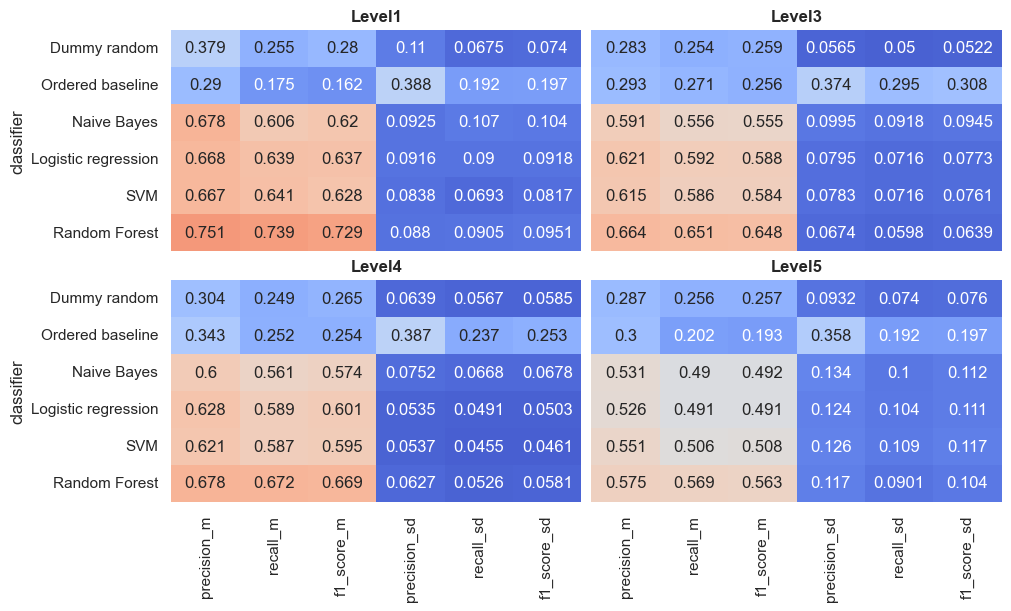

In [153]:
levels_best_classifier_score = {}

fig, axs = plt.subplots(2,2, constrained_layout=True,figsize=[10,6])
index = 0
FSCORE_INDEX = 2
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
      
    col = index % 2
    row = index // 2
    cbar = False
    if col == 2:
        cbar= True
    sns.heatmap(levels_results_grid_stats[level_key], ax = axs[row,col], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=cbar)
    axs[row,col].set_title(level_key,fontweight='bold')
    if row == 0 :
        axs[row,col].get_xaxis().set_visible(False)
    if col !=0 :
        axs[row,col].get_yaxis().set_visible(False)
    
    best_classifier = levels_results_grid_stats[level_key].sort_values(by=["f1_score_m"], ascending=False).iloc[0]
    levels_best_classifier_score[level_key] = best_classifier[FSCORE_INDEX]
    print(f"Best classifier : {best_classifier.name}, F1_score : {best_classifier[FSCORE_INDEX]}")
    index += 1
plt.savefig(f"outputdata/Pyrates_performancetable_hypertuning_{EXPORT_SUFFIX}.png")
plt.show()

## 9) Compute confusion matrices

**From this point onward we focus on examining the best classifier only (i.e., the one that yield the best performances).**

In [130]:
#for now we only do it for one model
best_classifier = "Random Forest"

Confusion matrices are generated both in a normiazed way (proportion of correct prediction), and in a sbsolute way (total number of correct predictions).

------------------ Normalized Matrices ------------------
------------------ Level1  ------------------


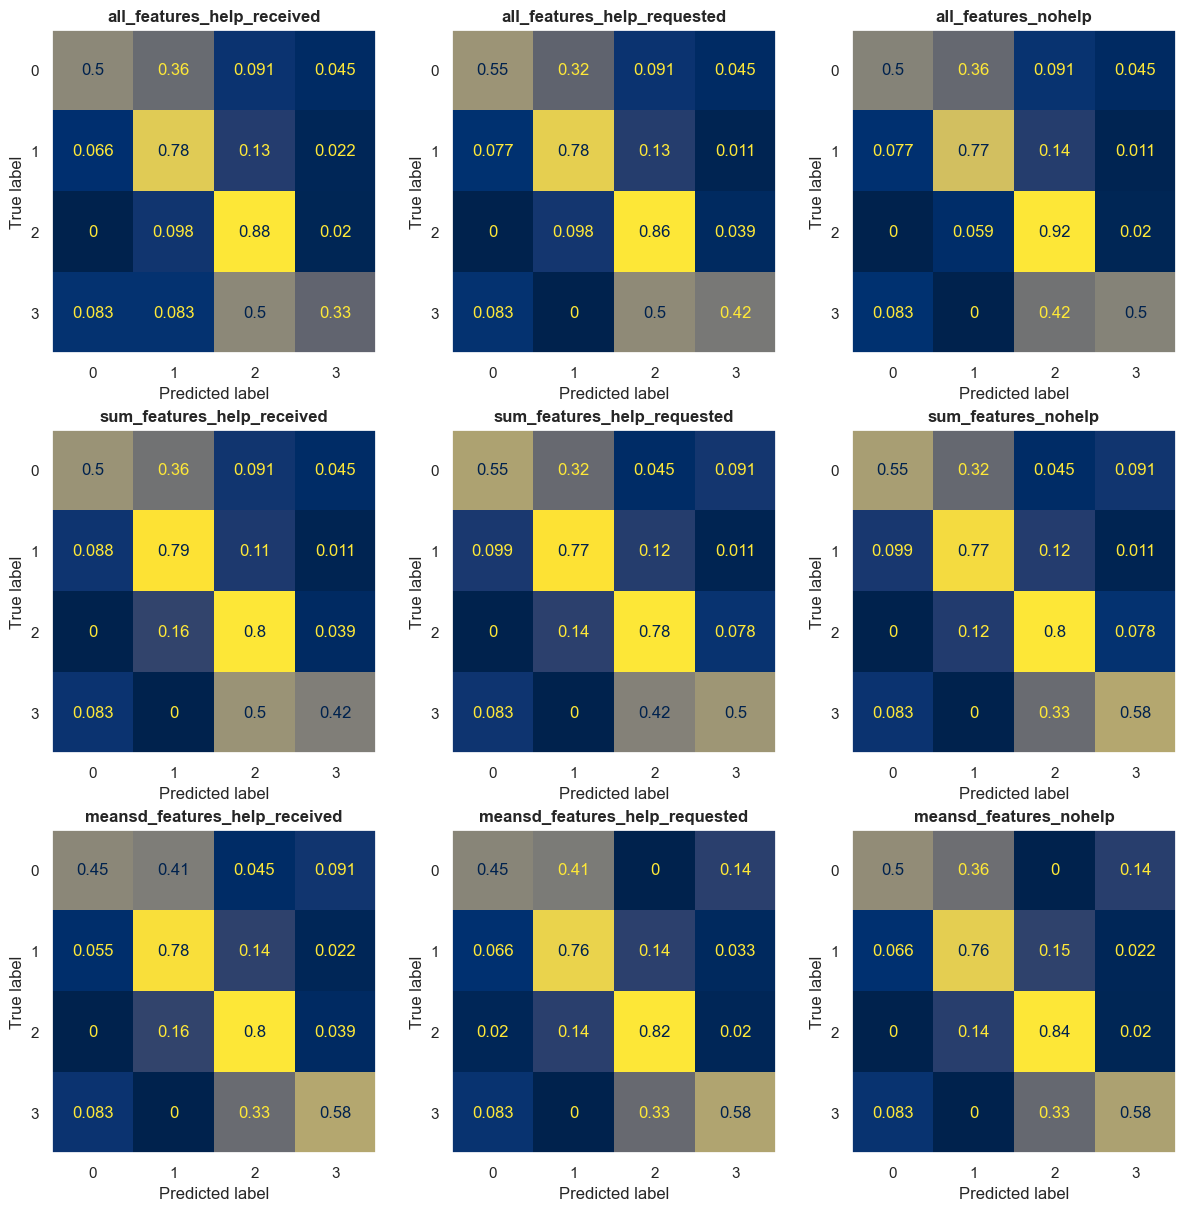

------------------ Level3  ------------------


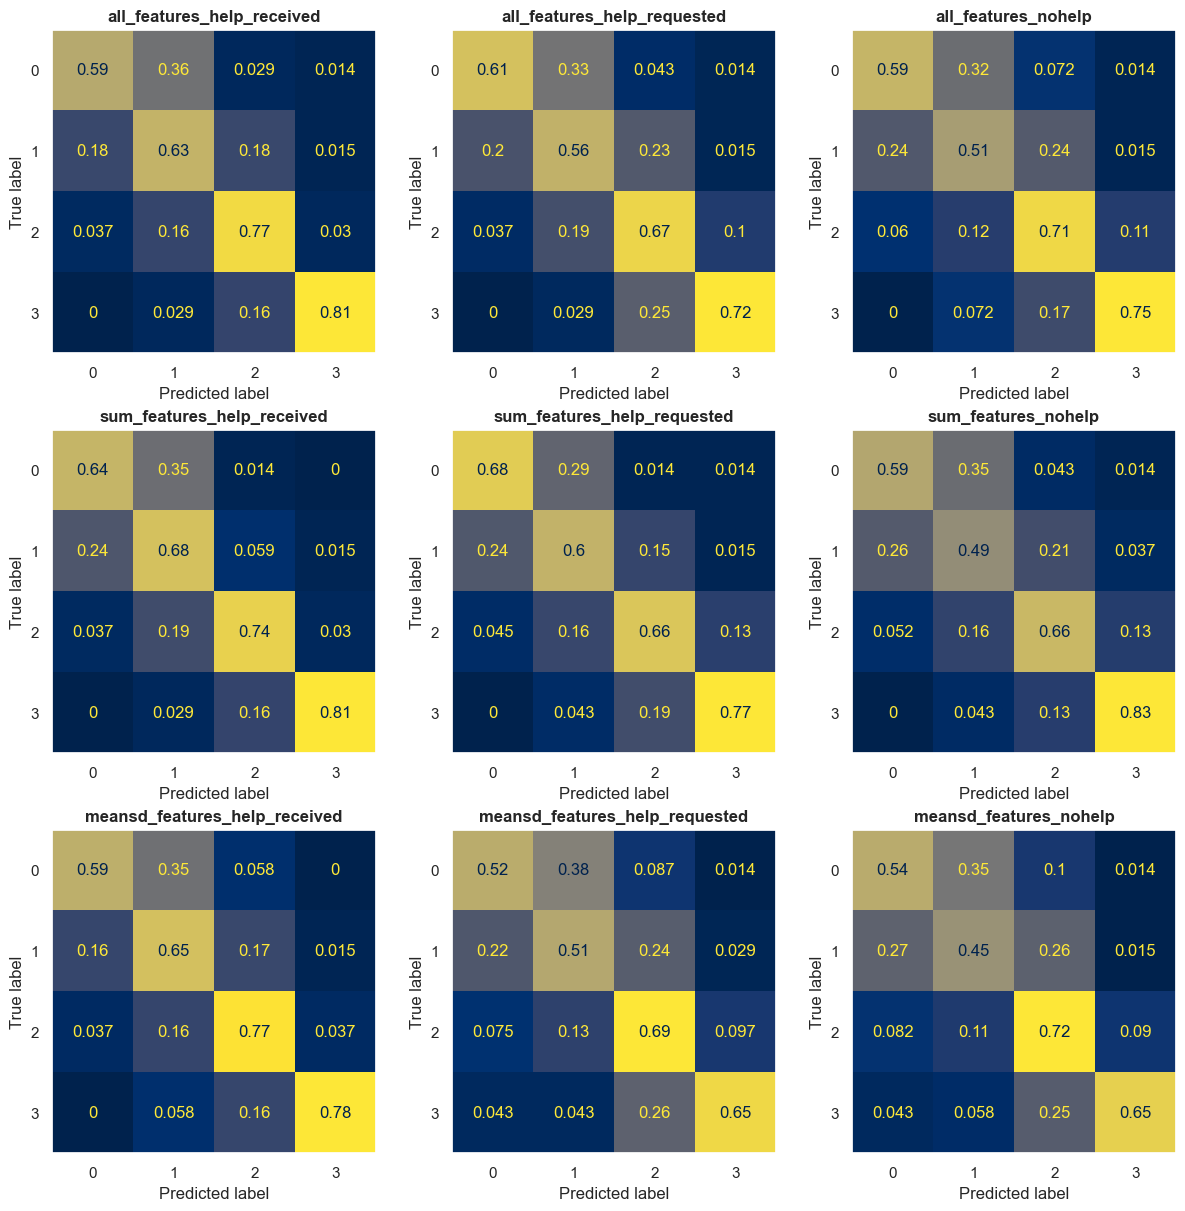

------------------ Level4  ------------------


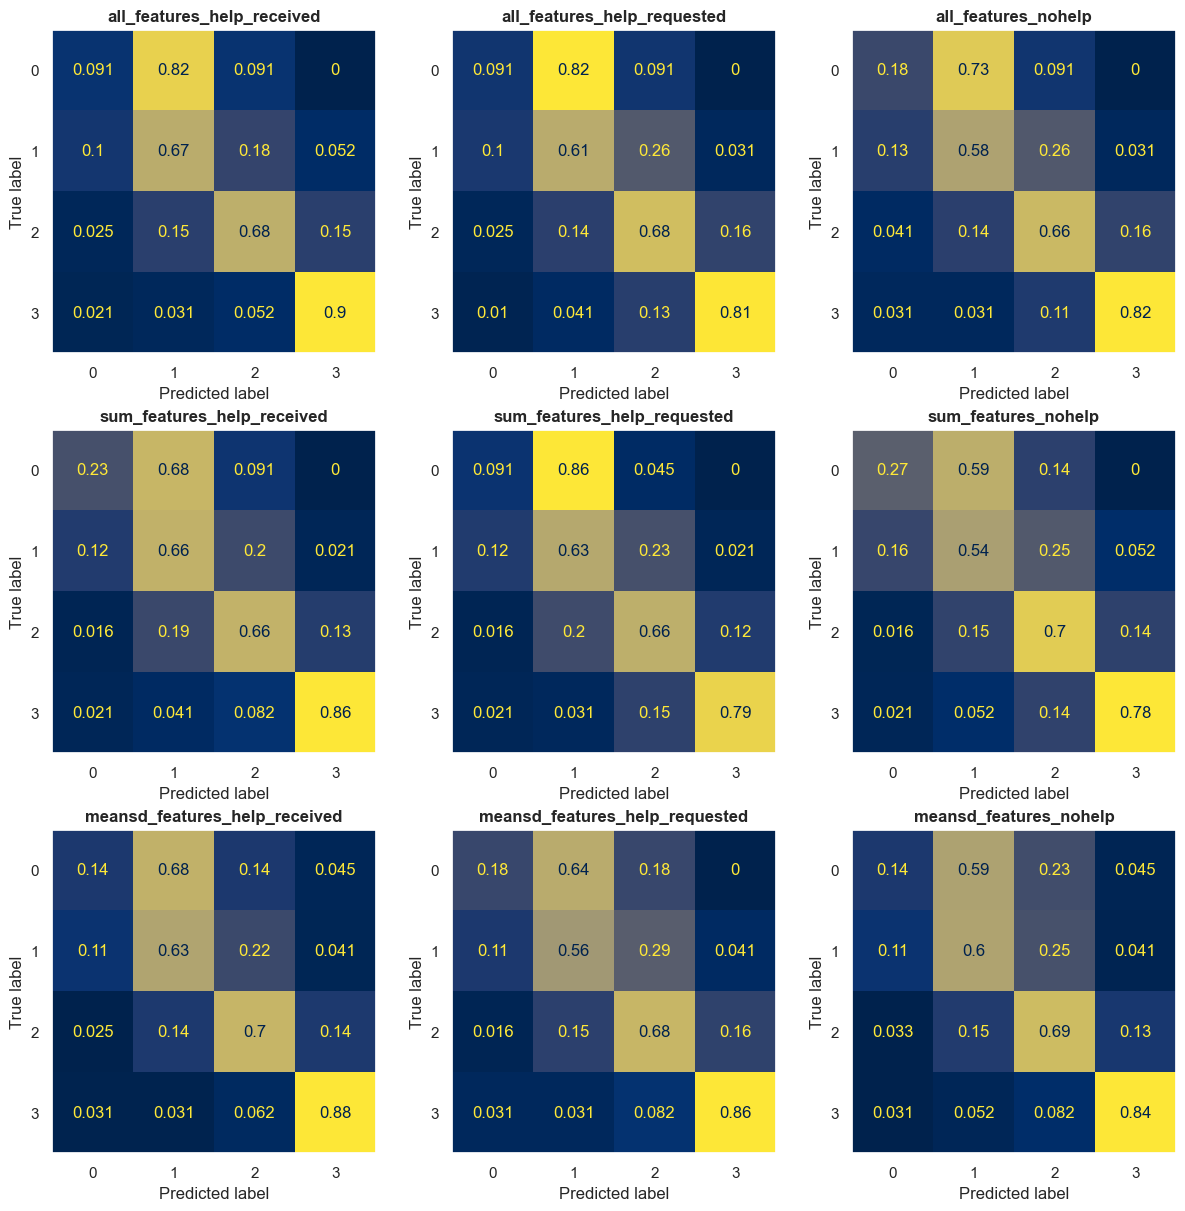

------------------ Level5  ------------------


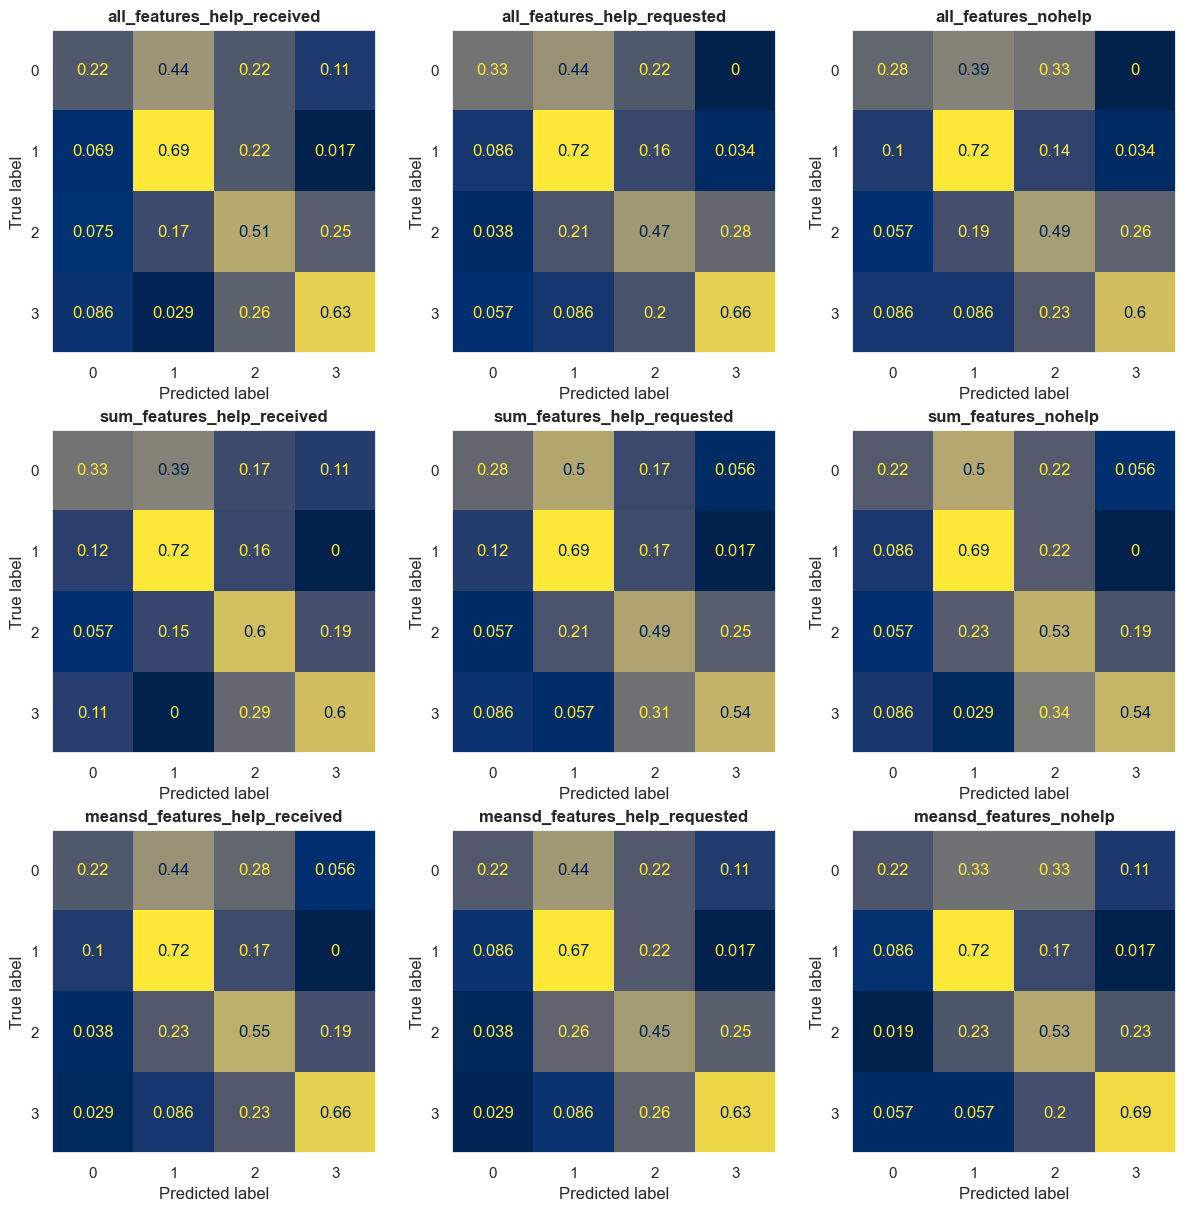

In [152]:
print(f"------------------ Normalized Matrices ------------------")
for level_key in levels_grid_classifier.keys():
    index = 0
    fig, axs = plt.subplots(3,3, constrained_layout=True,figsize=[12,12])
    
    print(f"------------------ {level_key}  ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        col = index % 3
        row = index // 3
        level_test_set_labels = pred_labels[level_key][fset_key][best_classifier]
        level_test_set_predictions = pred_results[level_key][fset_key][best_classifier] 
        ConfusionMatrixDisplay.from_predictions(level_test_set_labels, level_test_set_predictions, ax = axs[row,col], colorbar = False, cmap="cividis", normalize="true")

        axs[row,col].grid(False)
        axs[row,col].set_title(fset_key,fontweight='bold')
        #sns.heatmap(levels_results_grid_stats[level_key][["precision_m","recall_m","f1_score_m"]], yticklabels= [best_classifier], xticklabels= ["Precision","Recall","F1_score"], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=False, ax=axs[2*row+1,col])
        index +=1
    plt.savefig(f"outputdata/Pyrates_confmatrelative_hypertuning_{best_classifier}_{EXPORT_SUFFIX}.png")
    plt.show()

------------------ Absolute Matrices ------------------
------------------ Level1  ------------------


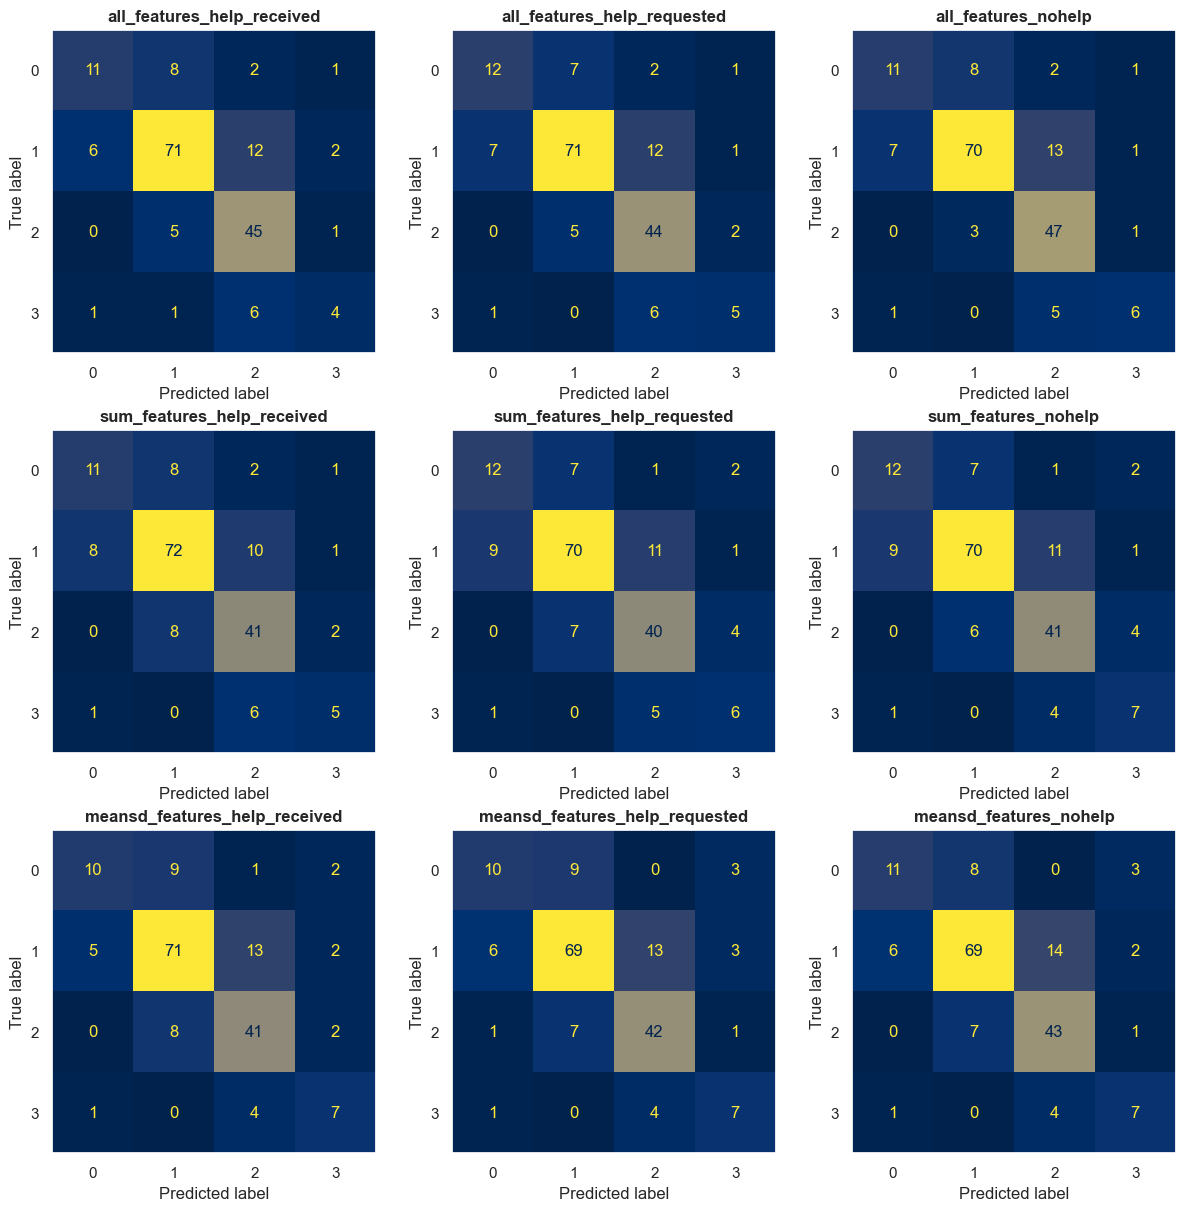

------------------ Level3  ------------------


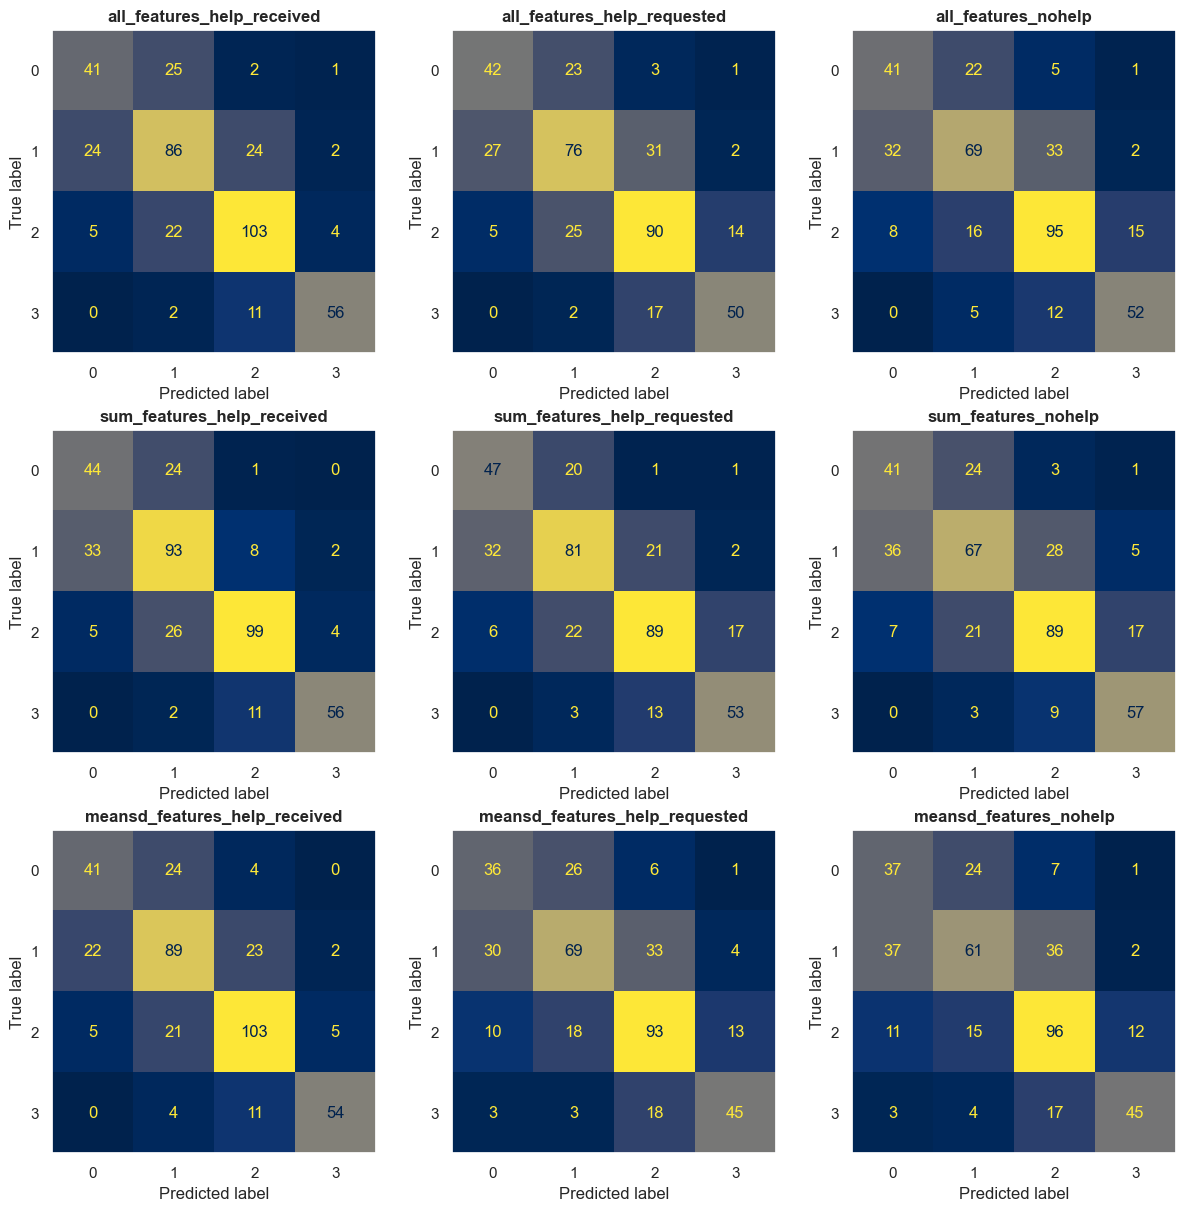

------------------ Level4  ------------------


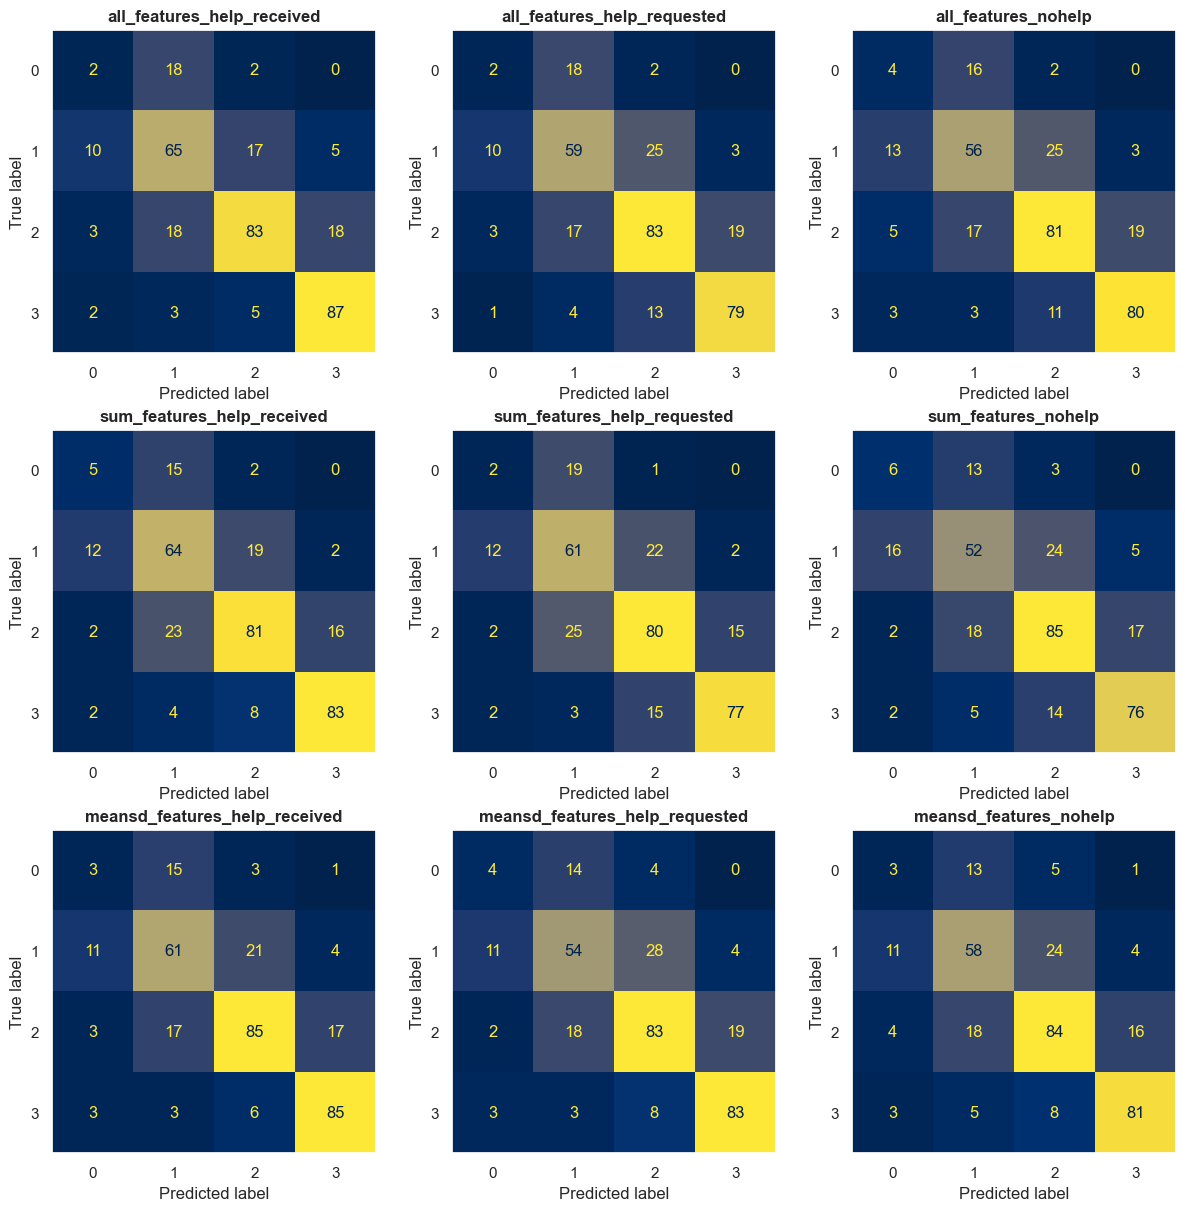

------------------ Level5  ------------------


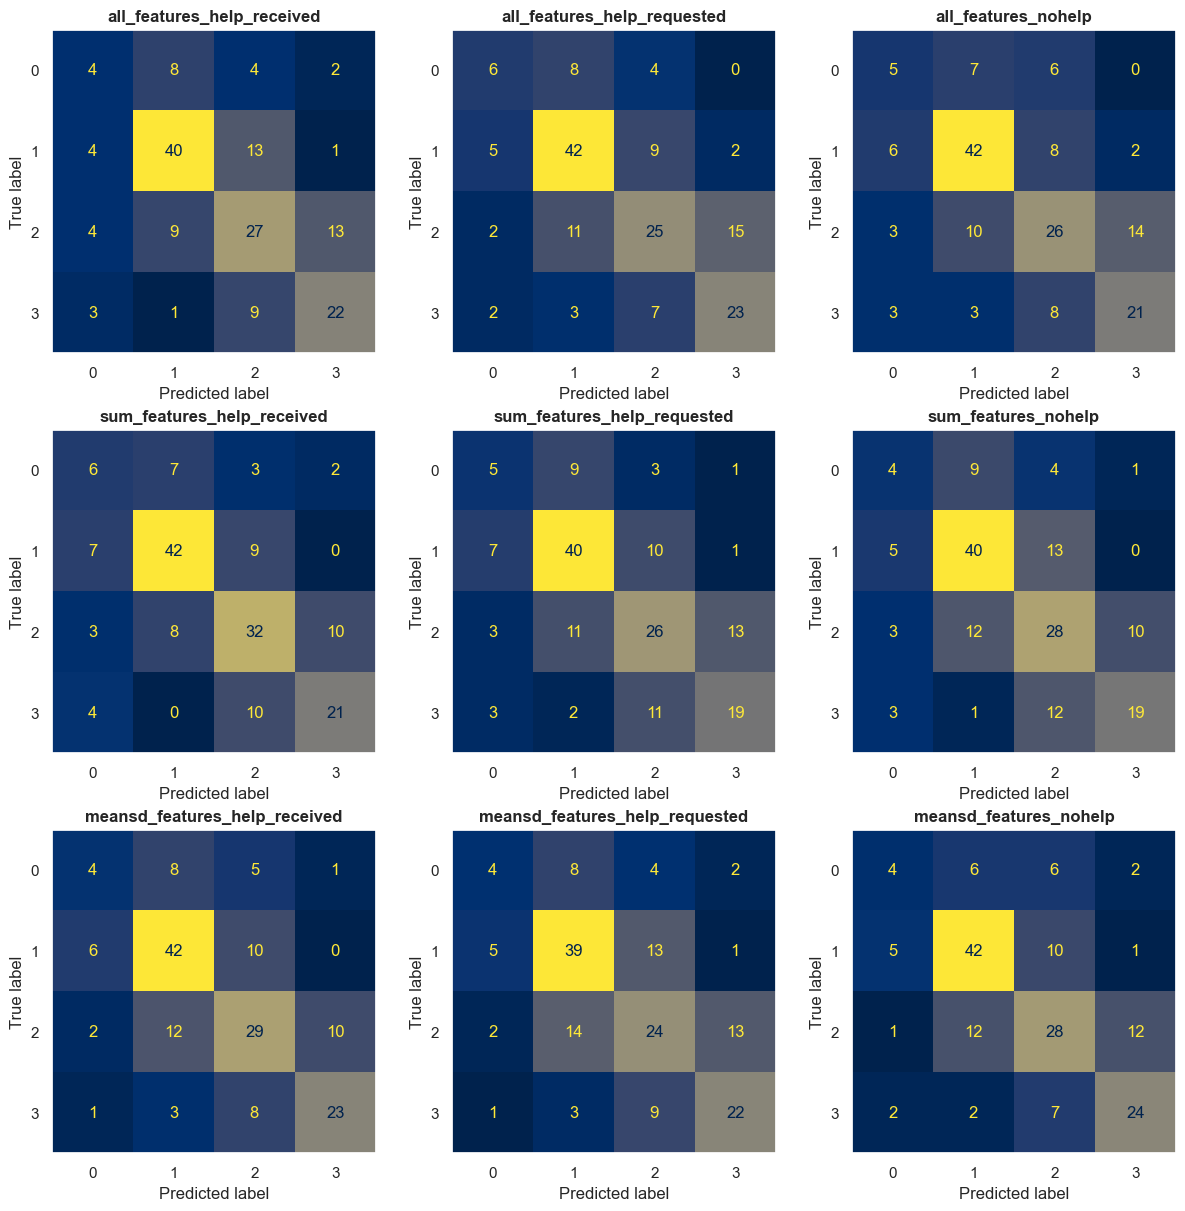

In [151]:
print(f"------------------ Absolute Matrices ------------------")
for level_key in levels_grid_classifier.keys():
    index = 0
    fig, axs = plt.subplots(3,3, constrained_layout=True,figsize=[12,12])
    
    print(f"------------------ {level_key}  ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        col = index % 3
        row = index // 3
        level_test_set_labels = pred_labels[level_key][fset_key][best_classifier]
        level_test_set_predictions = pred_results[level_key][fset_key][best_classifier] 
        ConfusionMatrixDisplay.from_predictions(level_test_set_labels, level_test_set_predictions, ax = axs[row,col], colorbar = False, cmap="cividis", normalize=None)

        axs[row,col].grid(False)
        axs[row,col].set_title(fset_key,fontweight='bold')
        #sns.heatmap(levels_results_grid_stats[level_key][["precision_m","recall_m","f1_score_m"]], yticklabels= [best_classifier], xticklabels= ["Precision","Recall","F1_score"], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=False, ax=axs[2*row+1,col])
        index +=1
    plt.savefig(f"outputdata/Pyrates_confmatabsolute_hypertuning_{best_classifier}_{EXPORT_SUFFIX}.png")
    plt.show()

## 10) Most important features

We compute and export the most important features selected in the best classifier to further understand what the model actually learned.
In our case the best classifiers was Rabdom Forest and feature important is computed using the permutation feature importance feature of sklearn.

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled : https://scikit-learn.org/stable/modules/permutation_importance.html

/!\ When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.

In [137]:
resimportance = []

for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    
    for fset_key, fset_columns in FEATURES_SETS.items():
        print(f"    --------------- {fset_key} ---------------")
        
        fset_dataframe = level_processed_dataframe[fset_columns]
    
        for k in range(NBFOLDS):
            print(f"------------------ {k} ------------------")      
            (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
            level_train_set = fset_dataframe.iloc[level_train_set_index]
            level_test_set = fset_dataframe.iloc[level_test_set_index]

            #level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe) #for the baselines
            level_train_set_features, level_train_set_labels, level_train_set_groups  = feature_label_group_split(level_train_set)
            level_test_set_features, level_test_set_labels  = feature_label_split(level_test_set)

            level_permutation_importance = permutation_importance(levels_grid_classifier[level_key][fset_key][best_classifier][k], level_train_set_features, level_train_set_labels,scoring="f1_weighted", n_repeats=10,random_state=42, n_jobs=-1)
            resimportance += [{"level_key": level_key, \
                     "features_set": fset_key, \
                     "classifier": best_classifier, \
                     "K": k, \
                     "feature": level_train_set_features.keys()[i],  \
                     "importance": level_permutation_importance.importances_mean[i] } \
                    for i in range(len(level_permutation_importance.importances_mean)) \
                    ]

levels_grid_features_importance = pd.DataFrame.from_records(resimportance) 
print("Done")


------------------ Level1 ------------------
    --------------- all_features_help_received ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- all_features_help_requested ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- all_features_nohelp ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- sum_features_help_received ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 --------

------------------ 3 ------------------
------------------ 4 ------------------
    --------------- sum_features_help_requested ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- sum_features_nohelp ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- meansd_features_help_received ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- meansd_features_help_requested ---------------
------------------ 0 ------------------
------------------ 1 ------

Display the feature importance values in charts

------------------ Feature importance ------------------
------------------ Level1  ------------------
-------------------------- all_features_nohelp  ----------------------------
-------------------------- sum_features_nohelp  ----------------------------
-------------------------- meansd_features_nohelp  ----------------------------
------------------ Level3  ------------------
-------------------------- all_features_nohelp  ----------------------------
-------------------------- sum_features_nohelp  ----------------------------
-------------------------- meansd_features_nohelp  ----------------------------
------------------ Level4  ------------------
-------------------------- all_features_nohelp  ----------------------------
-------------------------- sum_features_nohelp  ----------------------------
-------------------------- meansd_features_nohelp  ----------------------------
------------------ Level5  ------------------
-------------------------- all_features_nohelp  ---------

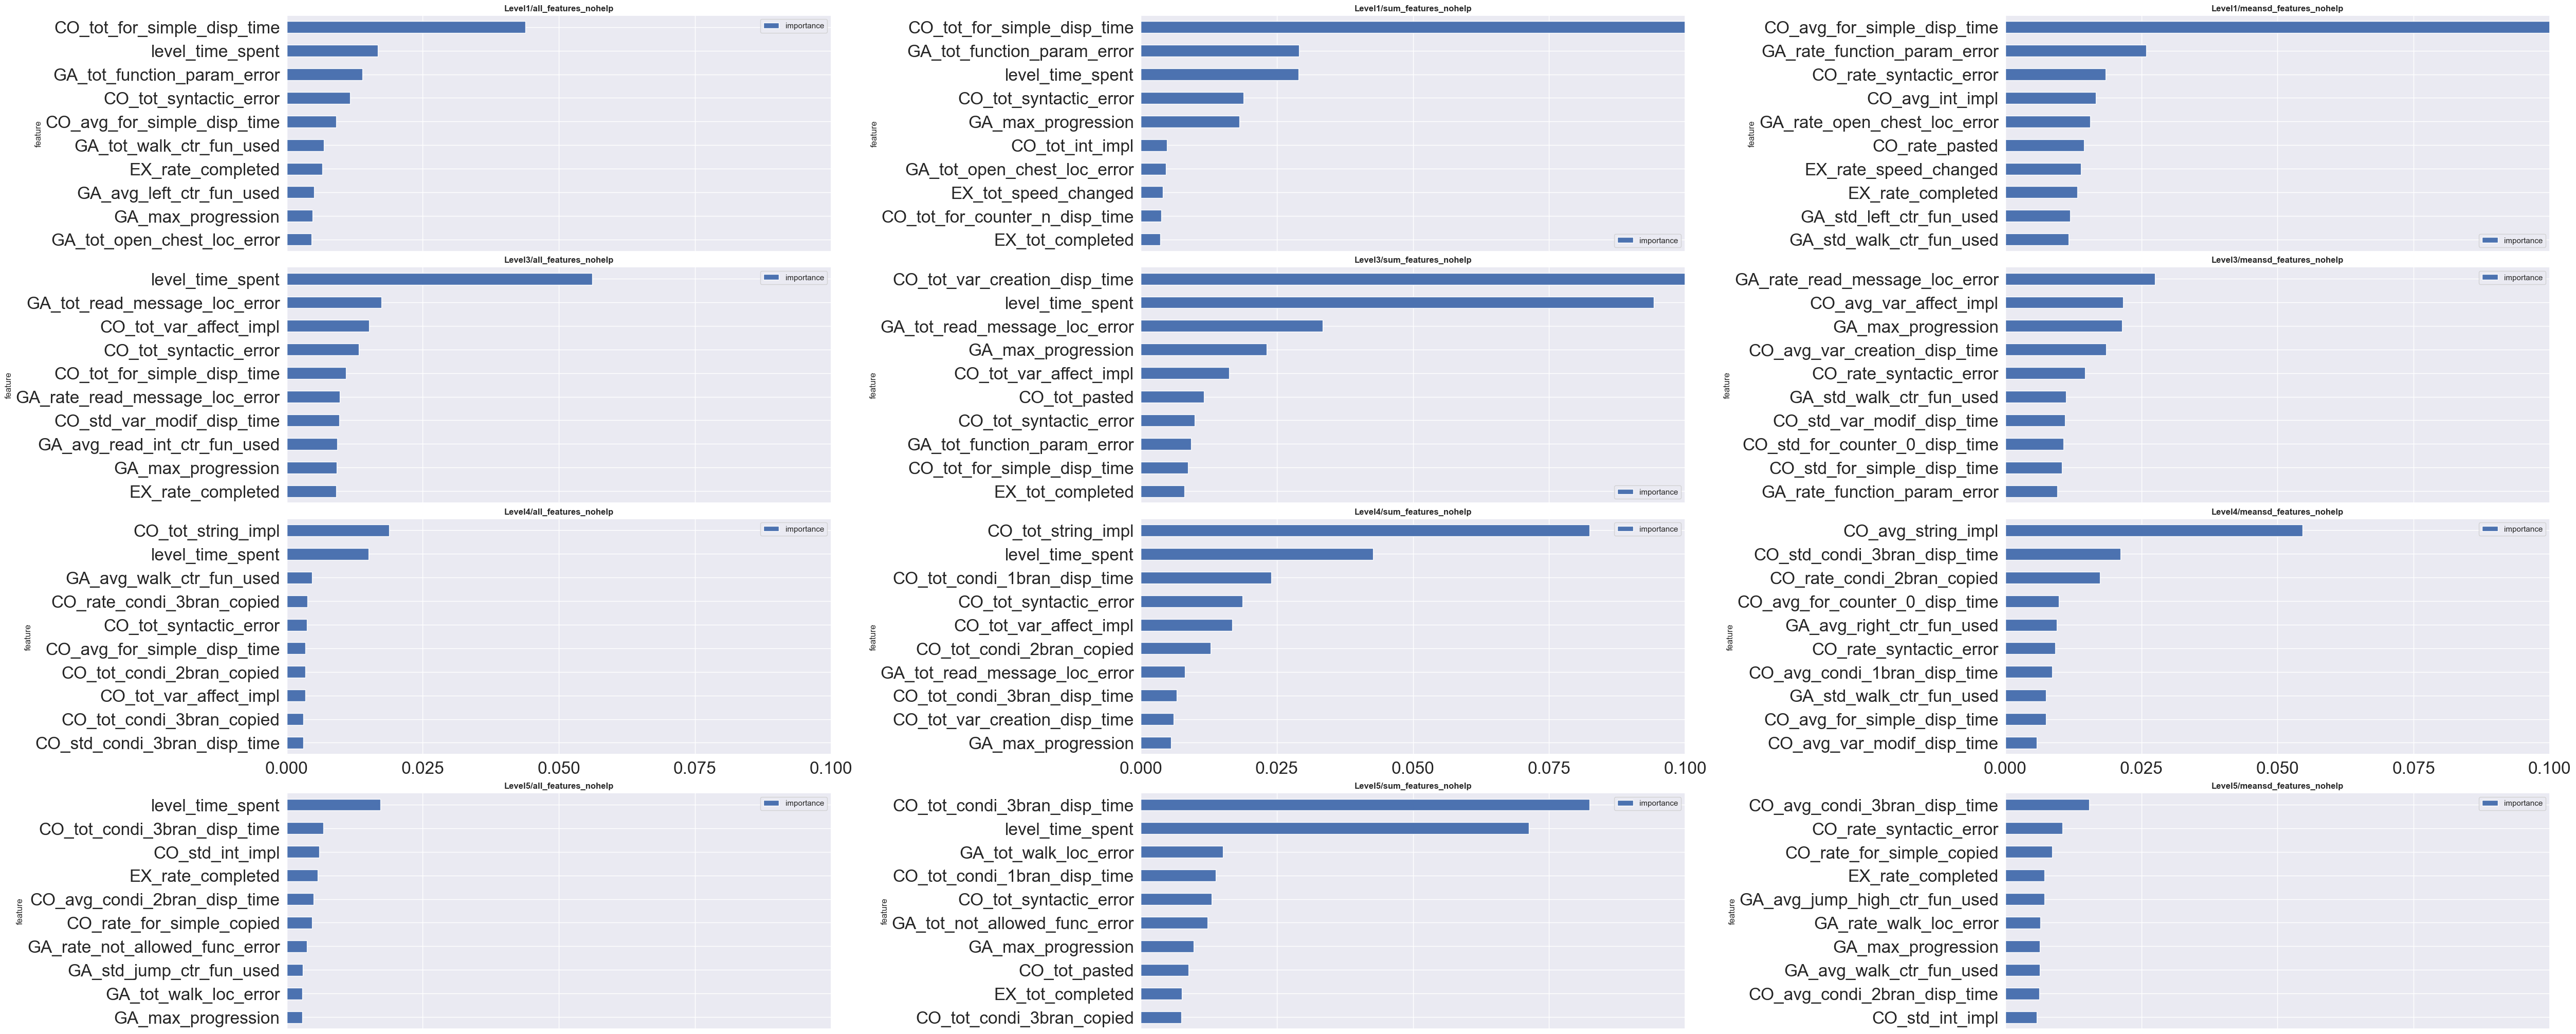

In [150]:
#Feature importance per level and feat set
print(f"------------------ Feature importance ------------------")
fig, axs = plt.subplots(4,3, constrained_layout=True,figsize=[50,20])
index = 0

for level_key in levels_grid_classifier.keys():
    print(f"------------------ {level_key}  ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        if "nohelp" not in fset_key:
            continue
        print(f"-------------------------- {fset_key}  ----------------------------")
        col = index % 3
        row = index // 3
        #level_test_set_labels = pred_labels[level_key][fset_key][best_classifier]
        #level_test_set_predictions = pred_results[level_key][fset_key][best_classifier] 
        #ConfusionMatrixDisplay.from_predictions(level_test_set_labels, level_test_set_predictions, ax = axs[row,col], colorbar = False, cmap="cividis", normalize="true")
        imp = levels_grid_features_importance[(levels_grid_features_importance["level_key"]==level_key) & \
                                      (levels_grid_features_importance["features_set"]==fset_key)]
        imp = imp.groupby(by=["feature"]).mean()
        imp = imp.sort_values(by="importance", ascending=False).head(10).drop("K", axis=1)
        imp.plot.barh(ax = axs[row,col])
        
        #axs[row,col].grid(False)
        axs[row,col].invert_yaxis()
        axs[row,col].set_xlim([0, 0.1])
        axs[row,col].set_xticks([0,0.025,0.05,0.075,0.1])
        for label in (axs[row,col].get_xticklabels() + axs[row,col].get_yticklabels()):
            label.set_fontsize(24)
        if row != 2:
            axs[row,col].set_xticklabels(["","","","",""])
        axs[row,col].set_title(f"{level_key}/{fset_key}",fontweight='bold')
        #sns.heatmap(levels_results_grid_stats[level_key][["precision_m","recall_m","f1_score_m"]], yticklabels= [best_classifier], xticklabels= ["Precision","Recall","F1_score"], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=False, ax=axs[2*row+1,col])
        index +=1
plt.savefig(f"outputdata/Pyrates_featureimp_hypertuning_{best_classifier}_{EXPORT_SUFFIX}.png")
plt.show()
    
    


# Pickle and CSV dumps

In [145]:
# Models with no hyperparameter tuning
if levels_results is not None:
    levels_results.to_csv(f"outputdata/Pyrates_model_results_notuning_{NBFOLDS}folds{EXPORT_SUFFIX}.csv", index=False)
    with open(f"pickle/levels_results_notuning{EXPORT_SUFFIX}", 'wb') as f:
        pickle.dump(levels_results, f)
        
# Models with hyperparameter tuning    
#save results as a pickle and a CSV
if levels_results_grid is not None:
    levels_results_grid.to_csv(f"outputdata/Pyrates_model_results_hypertuning_{NBFOLDS}folds{EXPORT_SUFFIX}.csv", index=False)
    with open(f"pickle/levels_results_hypertuning{EXPORT_SUFFIX}", 'wb') as f:
        outputall = {
            "grid_results": levels_results_grid,    
            "grid_trained_classifiers": levels_grid_classifier,
            "grid_predictions":pred_results,
            "grid_true_labels": pred_labels
        }
        pickle.dump(outputall, f) 

#feature importance values
if levels_grid_features_importance is not None:
    levels_grid_features_importance.to_csv(f"outputdata/Pyrates_model_featureimp_hypertuning_{best_classifier}_{NBFOLDS}folds_{EXPORT_SUFFIX}.csv", index=False)
    with open(f"pickle/levels_results_featuresimportance{EXPORT_SUFFIX}", 'wb') as f:
        pickle.dump(levels_grid_features_importance, f)
    